# Installations

In [ ]:
# !pip install split-folders
# !pip install tensorboard
# !pip install seaborn

  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl.metadata (18 kB)
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.8 MB 1.7 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/10.8 MB 2.9 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/10.8 MB 2.9 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/10.8 MB 3.0 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/10.8 MB 3.1 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/10.8 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 4.7/10.8 MB 3.1 MB/s eta 0:00:02
   -------------------- ------------------- 5.5/10.8 MB 3.1 MB/s eta 0:00:02
   ----------------------- ---------------- 6.3/10.8 MB 3.1 MB/s eta 0:00:02
   ------------------------- -------------- 6.8/10.8 MB 3.1 MB/s eta 0:00:02
   ----------------------------- ---------- 7.9/10.8 MB 3.2 MB/s eta 0:00:01
   -----------

# Imports

In [10]:
import random
import splitfolders
import os
import json
import shutil
from pathlib import Path
from typing import Optional, List, Union, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Set seed for deterministic results

In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Fetching Dataset

In [3]:
#!/bin/bash
# !curl -L -o ./five-crop-diseases-dataset.zip https://www.kaggle.com/api/v1/datasets/download/shubham2703/five-crop-diseases-dataset

In [ ]:
# !unzip -q /content/five-crop-diseases-dataset.zip 

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# !rm -rf "/content/Crop Diseases Dataset"
# !rm -rf /content/dataset

# Train-Test-Split

In [ ]:
# # !mkdir Data


# # !mv "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Corn/"* ./Data/
# # !mv "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Potato/"* ./Data/
# # !mv "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Wheat/"* ./Data/
# # !mv "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice/"* ./Data/
# # !mv "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/sugarcane/"* ./Data/

# # !rm -rf "./five-crop-diseases-dataset/Crop Diseases Dataset"

# import os
# import shutil

# # Create Data directory if it doesn't exist
# os.makedirs("Data", exist_ok=True)

# # List of crop folders to move
# crop_folders = [
#     "Corn",
#     "Potato",
#     "Wheat",
#     "Rice",
#     "sugarcane"
# ]

# base_path = "./five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/"

# # Move files from each crop folder into Data
# for crop in crop_folders:
#     src_folder = os.path.join(base_path, crop)
#     for file_name in os.listdir(src_folder):
#         src_file = os.path.join(src_folder, file_name)
#         dst_file = os.path.join("Data", file_name)
#         shutil.move(src_file, dst_file)

# # Remove the original dataset folder
# shutil.rmtree("./five-crop-diseases-dataset/Crop Diseases Dataset", ignore_errors=True)


In [ ]:
# splitfolders.ratio("Data", output="dataset",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # move =True if you need to move instead of copy.

Copying files: 0 files [00:00, ? files/s]

Copying files: 13324 files [08:24, 26.43 files/s]


# Data Loading

In [3]:
data_dir = "dataset"
img_size = 224
batch_size = 64
num_workers = os.cpu_count() // 2
print(num_workers)

6


In [4]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPosterize(bits=2),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5.)),
    transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Classes:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Classes: ['Bacterial Blight', 'Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Healthy', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Red Rot', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Train size: 10654
Val size: 1328
Test size: 1342


# Model

In [12]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Gadge/.cache\torch\hub\v0.10.0.zip
c:\Users\Gadge\anaconda3\envs\opensora\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gadge\anaconda3\envs\opensora\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Gadge/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:13<00:00, 3.57MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
num_classes = len(train_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # Replace last layer

# Training

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns


class Trainer:
    def __init__(self, model, train_loader, val_loader, device, lr=1e-3, log_dir="runs/exp1", best_path="./best.pth"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.writer = SummaryWriter(log_dir=log_dir)

        self.best_loss = float('inf') 
        self.best_path = best_path

    def train(self, epochs):
        for epoch in range(epochs):
            # Training loop
            self.model.train()
            train_loss, correct, total = 0, 0, 0

            loop = tqdm(self.train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

                loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

            epoch_loss = train_loss / total
            epoch_acc = 100. * correct / total
            self.writer.add_scalar("Loss/train", epoch_loss, epoch)
            self.writer.add_scalar("Accuracy/train", epoch_acc, epoch)

            # Validation loop
            self.validate(epoch)

    def validate(self, epoch):
        self.model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        if val_loss > self.best_loss:
            self.best_loss = val_loss
            torch.save(model, self.best_path)

        val_loss /= total
        val_acc = 100. * correct / total
        print(f"Validation: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        self.writer.add_scalar("Loss/val", val_loss, epoch)
        self.writer.add_scalar("Accuracy/val", val_acc, epoch)

    def test(self, test_loader, class_names):
        """Evaluate model on test set, show confusion matrix & sample predictions."""
        self.model.eval()
        correct, total, test_loss = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                test_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= total
        test_acc = 100. * correct / total
        print(f"\nTest: Loss={test_loss:.4f}, Acc={test_acc:.2f}%")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.title("Confusion Matrix")
        self.writer.add_figure("ConfusionMatrix", fig)
        plt.close(fig)

        # Show sample correct & incorrect predictions
        self._show_predictions(test_loader, class_names)

    def _show_predictions(self, test_loader, class_names, num_images=5):
        """Print some correct and incorrect predictions with images."""
        self.model.eval()
        shown_correct, shown_incorrect = 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, preds = outputs.max(1)

                for i in range(len(labels)):
                    if preds[i] == labels[i] and shown_correct < num_images:
                        print(f"Correct: {class_names[labels[i]]}")
                        self._plot_image(images[i], class_names[preds[i]])
                        shown_correct += 1
                    elif preds[i] != labels[i] and shown_incorrect < num_images:
                        print(f"Wrong: Pred={class_names[preds[i]]}, True={class_names[labels[i]]}")
                        self._plot_image(images[i], f"P:{class_names[preds[i]]} | T:{class_names[labels[i]]}")
                        shown_incorrect += 1

                    if shown_correct >= num_images and shown_incorrect >= num_images:
                        return

    def _plot_image(self, tensor_img, title):
        """Helper: plot a single image tensor."""
        img = tensor_img.cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # de-normalize
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.show()


In [6]:
os.cpu_count()

12

In [7]:
epochs = 25
lr = 1e-3
model_name = "resnet18"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
%load_ext tensorboard
%tensorboard --logdir runs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3960), started 0:05:22 ago. (Use '!kill 3960' to kill it.)

In [32]:
# Trainer
trainer = Trainer(model, train_loader, val_loader, device, lr=lr, log_dir=f"runs/{model_name}")
trainer.train(epochs=epochs)

Epoch [1/25]: 100%|██████████| 42/42 [07:34<00:00, 10.82s/it, acc=80.1, loss=0.267] 


Validation: Loss=0.6908, Acc=74.85%


Epoch [2/25]: 100%|██████████| 42/42 [08:24<00:00, 12.01s/it, acc=88.7, loss=0.283]  


Validation: Loss=0.3924, Acc=85.09%


Epoch [3/25]: 100%|██████████| 42/42 [08:32<00:00, 12.20s/it, acc=89.9, loss=0.194]  


Validation: Loss=0.4043, Acc=85.92%


Epoch [4/25]: 100%|██████████| 42/42 [07:16<00:00, 10.39s/it, acc=90.8, loss=0.196] 


Validation: Loss=0.3457, Acc=85.02%


Epoch [5/25]: 100%|██████████| 42/42 [08:18<00:00, 11.88s/it, acc=91.5, loss=0.213] 


Validation: Loss=0.3927, Acc=85.99%


Epoch [6/25]: 100%|██████████| 42/42 [07:54<00:00, 11.29s/it, acc=91.2, loss=0.182] 


Validation: Loss=0.3220, Acc=88.48%


Epoch [7/25]: 100%|██████████| 42/42 [07:51<00:00, 11.22s/it, acc=91.6, loss=0.226] 


Validation: Loss=0.3107, Acc=89.53%


Epoch [8/25]: 100%|██████████| 42/42 [07:10<00:00, 10.26s/it, acc=92.5, loss=0.166]


Validation: Loss=0.2394, Acc=90.81%


Epoch [9/25]: 100%|██████████| 42/42 [08:14<00:00, 11.77s/it, acc=92.9, loss=0.212]  


Validation: Loss=0.7177, Acc=83.51%


Epoch [10/25]: 100%|██████████| 42/42 [08:01<00:00, 11.47s/it, acc=93, loss=0.274]    


Validation: Loss=0.4212, Acc=87.50%


Epoch [11/25]:  29%|██▊       | 12/42 [03:59<09:58, 19.94s/it, acc=93.8, loss=0.143]


KeyboardInterrupt: 

# Testing

In [10]:
class TestRunner:
    """
    TestRunner evaluates a classification model on a test set (folder or DataLoader),
    plots confusion matrix, sample predictions, most-confident incorrect predictions,
    logs everything to TensorBoard and saves per-experiment CSV/JSON results for later comparison.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        test_dir: Optional[str] = None,
        test_loader: Optional[DataLoader] = None,
        device: Optional[torch.device] = None,
        batch_size: int = 64,
        num_workers: int = 4,
        transform: Optional[transforms.Compose] = None,
        log_dir: str = "runs/test",
        results_dir: str = "results/test",
        criterion: Optional[nn.Module] = None,
    ):
        assert (test_dir is not None) or (test_loader is not None), "Pass either test_dir or test_loader"
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.test_dir = test_dir
        self.test_loader = test_loader
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.log_dir = log_dir
        self.results_dir = results_dir
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.writer = SummaryWriter(log_dir=log_dir)

        # default transforms if not provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        os.makedirs(self.results_dir, exist_ok=True)

        # if test_dir given, build DataLoader
        if self.test_loader is None and self.test_dir is not None:
            dataset = datasets.ImageFolder(root=self.test_dir, transform=self.transform)
            self.class_names = dataset.classes
            self.test_loader = DataLoader(dataset, batch_size=self.batch_size,
                                          shuffle=False, num_workers=self.num_workers)
        elif self.test_loader is not None:
            # try to read class names from the dataset if possible
            try:
                self.class_names = self.test_loader.dataset.classes
            except Exception:
                self.class_names = None

        if self.class_names is None:
            # fallback
            self.class_names = [str(i) for i in range(1000)]

    def run(self, num_images_grid: int = 8, topk_incorrect: int = 20, save_csv: bool = True):
        """
        Evaluate the model on the test_loader and produce:
          - overall loss & accuracy
          - per-class precision/recall/f1
          - confusion matrix
          - plot sample correct & incorrect predictions (grid)
          - find most-confident incorrect predictions (high predicted probability but wrong)
          - save results as CSV/JSON
          - log figures to TensorBoard
        """
        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        all_preds = []
        all_labels = []
        all_probs = []  # probability of the predicted class
        all_images = []  # store small subset of images for plotting

        with torch.no_grad():
            loop = tqdm(self.test_loader, desc="Testing")
            for images, labels in loop:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)  # shape (B, C)

                loss = self.criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                probs = F.softmax(outputs, dim=1)
                confs, preds = torch.max(probs, dim=1)

                total_correct += preds.eq(labels).sum().item()
                total_samples += labels.size(0)

                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())
                all_probs.extend(confs.cpu().numpy().tolist())

                # store a few images for visual grid (as CPU tensors, de-normalized later)
                # store up to num_images_grid*2 images
                # if len(all_images) < num_images_grid * 2: # Remove this condition
                all_images.extend(images.cpu())


        avg_loss = total_loss / total_samples
        accuracy = 100.0 * total_correct / total_samples

        # Classification metrics
        precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, zero_division=0)
        class_report = classification_report(all_labels, all_preds, target_names=self.class_names, zero_division=0, output_dict=True)

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)

        # Save base results
        results = {
            "num_samples": int(total_samples),
            "loss": float(avg_loss),
            "accuracy": float(accuracy),
            "per_class": {self.class_names[i]: {
                "precision": float(precision[i]),
                "recall": float(recall[i]),
                "f1": float(f1[i]),
                "support": int(support[i])
            } for i in range(len(self.class_names))}
        }

        # Save json & csv summary
        if save_csv:
            # per-class csv
            perclass_rows = []
            for i, cname in enumerate(self.class_names):
                perclass_rows.append({
                    "class_idx": i,
                    "class_name": cname,
                    "precision": float(precision[i]),
                    "recall": float(recall[i]),
                    "f1": float(f1[i]),
                    "support": int(support[i])
                })
            df_perclass = pd.DataFrame(perclass_rows)
            perclass_csv = os.path.join(self.results_dir, "per_class_metrics.csv")
            df_perclass.to_csv(perclass_csv, index=False)

            # summary csv
            summary_df = pd.DataFrame([{
                "loss": avg_loss,
                "accuracy": accuracy,
                "num_samples": int(total_samples)
            }])
            summary_csv = os.path.join(self.results_dir, "summary.csv")
            summary_df.to_csv(summary_csv, index=False)

            # json
            json_path = os.path.join(self.results_dir, "results.json")
            with open(json_path, "w") as f:
                json.dump(results, f, indent=2)

        # Log scalars to TensorBoard
        self.writer.add_scalar("Test/Loss", avg_loss, 0)
        self.writer.add_scalar("Test/Accuracy", accuracy, 0)

        # Log per-class metrics as text and scalars (macro)
        macro_precision = float(np.nanmean(precision))
        macro_recall = float(np.nanmean(recall))
        macro_f1 = float(np.nanmean(f1))
        self.writer.add_scalar("Test/MacroPrecision", macro_precision, 0)
        self.writer.add_scalar("Test/MacroRecall", macro_recall, 0)
        self.writer.add_scalar("Test/MacroF1", macro_f1, 0)

        # Plot & save confusion matrix figure
        cm_fig = self._plot_confusion_matrix(cm, self.class_names, normalize=False)
        cm_path = os.path.join(self.results_dir, "confusion_matrix.png")
        cm_fig.savefig(cm_path, bbox_inches="tight")
        self.writer.add_figure("ConfusionMatrix", cm_fig)
        plt.close(cm_fig)

        # Plot normalized confusion matrix
        cm_norm_fig = self._plot_confusion_matrix(cm, self.class_names, normalize=True)
        cm_norm_path = os.path.join(self.results_dir, "confusion_matrix_norm.png")
        cm_norm_fig.savefig(cm_norm_path, bbox_inches="tight")
        self.writer.add_figure("ConfusionMatrix_Normalized", cm_norm_fig)
        plt.close(cm_norm_fig)

        # Save a couple of image grids (correct vs incorrect)
        grid_fig = self._plot_prediction_grid(all_images[:num_images_grid], all_labels[:num_images_grid], all_preds[:num_images_grid], self.class_names, num_images=num_images_grid)
        grid_path = os.path.join(self.results_dir, "prediction_grid.png")
        grid_fig.savefig(grid_path, bbox_inches="tight")
        self.writer.add_figure("SamplePredictions", grid_fig)
        plt.close(grid_fig)

        # Find most confident incorrect predictions
        top_incorrect_fig = self._plot_most_confident_incorrects(
            probs=np.array(all_probs),
            preds=np.array(all_preds),
            labels=np.array(all_labels),
            images=all_images,
            class_names=self.class_names,
            topk=topk_incorrect
        )
        if top_incorrect_fig is not None:
            top_incorrect_path = os.path.join(self.results_dir, "most_confident_incorrects.png")
            top_incorrect_fig.savefig(top_incorrect_path, bbox_inches="tight")
            self.writer.add_figure("MostConfidentIncorrects", top_incorrect_fig)
            plt.close(top_incorrect_fig)

        # Save a CSV with overall and per-class metrics for easy aggregation across experiments
        if save_csv:
            out_csv = os.path.join(self.results_dir, "metrics_for_aggregation.csv")
            rows = []
            for i, cname in enumerate(self.class_names):
                rows.append({
                    "experiment": os.path.basename(self.results_dir.rstrip('/')),
                    "class_idx": i,
                    "class_name": cname,
                    "precision": float(precision[i]),
                    "recall": float(recall[i]),
                    "f1": float(f1[i]),
                    "support": int(support[i]),
                    "overall_accuracy": accuracy,
                    "overall_loss": avg_loss
                })
            pd.DataFrame(rows).to_csv(out_csv, index=False)

        print(f"\nTest results saved to {self.results_dir}")
        print(f"Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")
        return results

    # -------------------------
    # Helper plotting functions
    # -------------------------
    def _plot_confusion_matrix(self, cm: np.ndarray, class_names: List[str], normalize: bool = False):
        """
        Return a matplotlib figure for the confusion matrix.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        if normalize:
            cm_sum = cm.sum(axis=1)[:, np.newaxis]
            cm_plot = np.divide(cm, cm_sum, where=cm_sum != 0)
            sns.heatmap(cm_plot, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_title("Normalized Confusion Matrix")
        else:
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_title("Confusion Matrix (Counts)")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        return fig

    def _denormalize(self, tensor_img: torch.Tensor):
        """Convert a normalized image tensor back to [0,1] numpy image for plotting."""
        img = tensor_img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)
        return img.permute(1, 2, 0).numpy()

    def _plot_prediction_grid(self, all_images: List[torch.Tensor], all_labels: List[int], all_preds: List[int],
                              class_names: List[str], num_images: int = 8):
        """
        Plot a grid of images showing predicted vs true label (a mix of correct + incorrect).
        """
        # Prepare a small selection
        n = min(len(all_images), num_images)
        fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
        for i in range(n):
            ax = axes[i] if n > 1 else axes
            img = self._denormalize(all_images[i])
            true = class_names[all_labels[i]]
            pred = class_names[all_preds[i]]
            ax.imshow(img)
            ax.set_title(f"T:{true}\nP:{pred}")
            ax.axis("off")
        plt.tight_layout()
        return fig

    def _plot_most_confident_incorrects(self, probs: np.ndarray, preds: np.ndarray, labels: np.ndarray,
                                        images: List[torch.Tensor], class_names: List[str], topk: int = 20):
        """
        Identify incorrect predictions where model was most confident, and plot topk of them.
        probs: predicted class probability for each item (same length as preds)
        """
        incorrect_mask = preds != labels
        if incorrect_mask.sum() == 0:
            print("No incorrect predictions to show.")
            return None

        incorrect_probs = probs[incorrect_mask]
        incorrect_indices = np.where(incorrect_mask)[0]
        # sort by descending predicted probability
        order = np.argsort(-incorrect_probs)
        topk_idx = incorrect_indices[order][:topk]

        n = len(topk_idx)
        cols = 5
        rows = max(1, int(np.ceil(n / cols)))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()
        for i, idx in enumerate(topk_idx):
            ax = axes[i]
            img = self._denormalize(images[idx])
            true = class_names[labels[idx]]
            pred = class_names[preds[idx]]
            conf = probs[idx]
            ax.imshow(img)
            ax.set_title(f"P:{pred} ({conf:.2f})\nT:{true}")
            ax.axis("off")
        # hide extra axes
        for j in range(n, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        return fig

    # -------------------------
    # Utilities for experiments
    # -------------------------
    @staticmethod
    def compare_runs(results_root: str, out_fig: Optional[str] = None):
        """
        Aggregate all 'metrics_for_aggregation.csv' under results_root
        and create a comparison table/plot for overall accuracy & per-class f1 across experiments.

        results_root: folder containing subfolders for each experiment (each should have metrics_for_aggregation.csv)
        """
        csv_paths = list(Path(results_root).rglob("metrics_for_aggregation.csv"))
        if len(csv_paths) == 0:
            raise FileNotFoundError("No metrics_for_aggregation.csv files found under " + str(results_root))

        dfs = []
        for p in csv_paths:
            df = pd.read_csv(p)
            # add experiment name if missing
            if 'experiment' not in df.columns:
                df['experiment'] = p.parent.name
            dfs.append(df)

        all_df = pd.concat(dfs, ignore_index=True)
        # overall accuracy per experiment: take first row's overall_accuracy (they're same per file)
        overall = all_df.groupby('experiment')[['overall_accuracy', 'overall_loss']].mean().reset_index()

        # Quick barplot: overall_accuracy
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.barplot(data=overall.sort_values('overall_accuracy', ascending=False), x='experiment', y='overall_accuracy', ax=ax)
        ax.set_ylabel("Accuracy (%)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        if out_fig:
            fig.savefig(out_fig, bbox_inches="tight")
        return all_df, fig

In [ ]:
from torchvision import datasets

test_data = datasets.ImageFolder("dataset/test")
print("Found classes:", test_data.classes)
print("Total images:", len(test_data))

Found classes: ['Bacterial Blight', 'Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Healthy', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Red Rot', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Total images: 1342


In [ ]:
tester = TestRunner(
    model,
    test_dir="dataset/test",
    device=device,
    log_dir="runs/test_exp1",
    results_dir="results/test_exp1",
    batch_size=64,
    num_workers=os.cpu_count() // 2
)

tester.run(num_images_grid=8, topk_incorrect=5)

Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Testing: 100%|██████████| 21/21 [00:44<00:00,  2.10s/it]



Test results saved to results/test_exp1
Accuracy: 91.28%, Loss: 0.2555


{'num_samples': 1342,
 'loss': 0.25554731630993843,
 'accuracy': 91.28166915052161,
 'per_class': {'Bacterial Blight': {'precision': 0.8,
   'recall': 0.8,
   'f1': 0.8000000000000002,
   'support': 10},
  'Corn___Common_Rust': {'precision': 0.9915966386554622,
   'recall': 0.9833333333333333,
   'f1': 0.9874476987447698,
   'support': 120},
  'Corn___Gray_Leaf_Spot': {'precision': 0.7846153846153846,
   'recall': 0.9807692307692307,
   'f1': 0.8717948717948717,
   'support': 52},
  'Corn___Healthy': {'precision': 0.9915254237288136,
   'recall': 1.0,
   'f1': 0.9957446808510638,
   'support': 117},
  'Corn___Northern_Leaf_Blight': {'precision': 0.8571428571428571,
   'recall': 0.9090909090909091,
   'f1': 0.8823529411764706,
   'support': 99},
  'Healthy': {'precision': 1.0,
   'recall': 0.6,
   'f1': 0.7499999999999999,
   'support': 10},
  'Potato___Early_Blight': {'precision': 1.0,
   'recall': 0.91,
   'f1': 0.9528795811518325,
   'support': 100},
  'Potato___Healthy': {'precision

# EfficientNet B2

In [8]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import torchvision.models as models

In [9]:
epochs = 20
lr = 1e-3
model_name = "efficientnet_b2"

model = models.efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

_ = model.eval()

trainer = Trainer(model, train_loader, val_loader, device, lr=lr, log_dir=f"runs/{model_name}", best_path=f"{model_name}_agri.pth")
trainer.train(epochs=epochs)

Using device: cuda


Epoch [1/20]: 100%|██████████| 167/167 [13:08<00:00,  4.72s/it, acc=83.7, loss=0.547]


Validation: Loss=0.2587, Acc=90.51%


Epoch [2/20]: 100%|██████████| 167/167 [13:01<00:00,  4.68s/it, acc=90.1, loss=0.338] 


Validation: Loss=0.2177, Acc=92.09%


Epoch [3/20]: 100%|██████████| 167/167 [13:10<00:00,  4.73s/it, acc=91.8, loss=0.355]


Validation: Loss=0.2383, Acc=90.44%


Epoch [4/20]: 100%|██████████| 167/167 [13:26<00:00,  4.83s/it, acc=92.4, loss=0.241] 


Validation: Loss=0.2028, Acc=92.32%


Epoch [5/20]: 100%|██████████| 167/167 [13:05<00:00,  4.70s/it, acc=92.9, loss=0.134] 


Validation: Loss=0.1876, Acc=93.00%


Epoch [6/20]: 100%|██████████| 167/167 [13:06<00:00,  4.71s/it, acc=93.4, loss=0.252] 


Validation: Loss=0.1940, Acc=93.00%


Epoch [7/20]: 100%|██████████| 167/167 [12:29<00:00,  4.49s/it, acc=94, loss=0.141]   


Validation: Loss=0.2108, Acc=93.22%


Epoch [8/20]: 100%|██████████| 167/167 [12:15<00:00,  4.41s/it, acc=93.9, loss=0.399] 


Validation: Loss=0.6754, Acc=85.69%


Epoch [9/20]: 100%|██████████| 167/167 [16:55<00:00,  6.08s/it, acc=94, loss=0.183]    


Validation: Loss=0.2069, Acc=92.24%


Epoch [10/20]: 100%|██████████| 167/167 [18:01<00:00,  6.47s/it, acc=94.1, loss=0.238] 


Validation: Loss=0.1932, Acc=93.00%


Epoch [11/20]: 100%|██████████| 167/167 [20:34<00:00,  7.39s/it, acc=94.6, loss=0.0403]  


Validation: Loss=0.1807, Acc=93.60%


Epoch [12/20]: 100%|██████████| 167/167 [13:24<00:00,  4.82s/it, acc=94.5, loss=0.329] 


Validation: Loss=0.1661, Acc=94.35%


Epoch [13/20]: 100%|██████████| 167/167 [13:18<00:00,  4.78s/it, acc=95, loss=0.0707]  


Validation: Loss=0.1680, Acc=94.50%


Epoch [14/20]: 100%|██████████| 167/167 [13:32<00:00,  4.86s/it, acc=95.2, loss=0.166] 


Validation: Loss=0.1359, Acc=94.95%


Epoch [15/20]: 100%|██████████| 167/167 [13:54<00:00,  5.00s/it, acc=95.2, loss=0.142] 


Validation: Loss=0.1996, Acc=93.60%


Epoch [16/20]: 100%|██████████| 167/167 [13:25<00:00,  4.82s/it, acc=95.1, loss=0.257] 


Validation: Loss=0.1843, Acc=94.95%


Epoch [17/20]: 100%|██████████| 167/167 [13:18<00:00,  4.78s/it, acc=95.1, loss=0.217] 


Validation: Loss=0.1974, Acc=93.75%


Epoch [18/20]: 100%|██████████| 167/167 [13:15<00:00,  4.77s/it, acc=95.2, loss=0.3]   


Validation: Loss=0.2310, Acc=93.00%


Epoch [19/20]: 100%|██████████| 167/167 [13:13<00:00,  4.75s/it, acc=95.2, loss=0.0963]


Validation: Loss=0.1807, Acc=93.07%


Epoch [20/20]: 100%|██████████| 167/167 [15:58<00:00,  5.74s/it, acc=95.4, loss=0.0401]


Validation: Loss=0.2472, Acc=93.67%


In [11]:
tester = TestRunner(
    model,
    test_dir="dataset/test",
    device=device,
    log_dir="runs/efficientnet_b2_test",
    results_dir="results/efficientnet_b2_test",
    batch_size=64,
    num_workers=os.cpu_count() // 2
)

tester.run(num_images_grid=8, topk_incorrect=5)

Testing: 100%|██████████| 21/21 [01:04<00:00,  3.07s/it]



Test results saved to results/efficientnet_b2_test
Accuracy: 93.82%, Loss: 0.2093


{'num_samples': 1342,
 'loss': 0.20931404340867069,
 'accuracy': 93.81520119225037,
 'per_class': {'Bacterial Blight': {'precision': 0.9,
   'recall': 0.9,
   'f1': 0.9,
   'support': 10},
  'Corn___Common_Rust': {'precision': 1.0,
   'recall': 0.9916666666666667,
   'f1': 0.99581589958159,
   'support': 120},
  'Corn___Gray_Leaf_Spot': {'precision': 1.0,
   'recall': 0.7307692307692307,
   'f1': 0.8444444444444443,
   'support': 52},
  'Corn___Healthy': {'precision': 0.9915254237288136,
   'recall': 1.0,
   'f1': 0.9957446808510638,
   'support': 117},
  'Corn___Northern_Leaf_Blight': {'precision': 0.8672566371681416,
   'recall': 0.98989898989899,
   'f1': 0.9245283018867925,
   'support': 99},
  'Healthy': {'precision': 1.0,
   'recall': 0.9,
   'f1': 0.9473684210526316,
   'support': 10},
  'Potato___Early_Blight': {'precision': 1.0,
   'recall': 1.0,
   'f1': 1.0,
   'support': 100},
  'Potato___Healthy': {'precision': 0.8421052631578947,
   'recall': 1.0,
   'f1': 0.9142857142857

# Contrastive Learning

In [101]:
class Siamese(nn.Module):
    def __init__(
        self, 
        backbone="resnet18", pretrained=True, 
        embedding_dim=128, freeze_backbone=True, 
        custom_weights: Optional[nn.Module] = None
    ):
        super().__init__()
        if backbone == "resnet18":
            if custom_weights:
                base = models.resnet18(weights=custom_weights)
            else:
                base = models.resnet18(pretrained=pretrained)
            in_features = base.fc.in_features
            base.fc = nn.Identity()  # remove final classifier
        else:
            raise NotImplementedError("Only resnet18 implemented here")

        self.backbone = base
        self.embedding = nn.Linear(in_features, embedding_dim)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)        # features
        x = self.embedding(x)       # project to embedding_dim
        x = F.normalize(x, p=2, dim=1)  # L2 normalize
        return x


In [102]:
class SiameseTripletDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        root: path to dataset root, structured as ImageFolder
        e.g. root/ClassName/*.jpg
        """
        self.dataset = datasets.ImageFolder(root=root, transform=transform)
        self.transform = transform

        # Map class -> indices
        self.class_to_indices = {}
        for idx, (_, label) in enumerate(self.dataset.samples):
            cls = self.dataset.classes[label]
            self.class_to_indices.setdefault(cls, []).append(idx)

        # Separate healthy and disease classes
        self.healthy_classes = [c for c in self.dataset.classes if "Healthy" in c]
        self.disease_classes = [c for c in self.dataset.classes if "Healthy" not in c]

        if not self.healthy_classes:
            raise ValueError("No healthy classes found in dataset!")

    def __len__(self):
        # length = total number of healthy samples
        return sum(len(self.class_to_indices[c]) for c in self.healthy_classes)

    def __getitem__(self, idx):
        # Pick a healthy class at random
        healthy_class = random.choice(self.healthy_classes)
        anchor_idx = random.choice(self.class_to_indices[healthy_class])
        anchor_img, _ = self.dataset[anchor_idx]

        # Positive (same healthy class)
        pos_idx = random.choice(self.class_to_indices[healthy_class])
        pos_img, _ = self.dataset[pos_idx]

        # Negative (any disease class)
        neg_class = random.choice(self.disease_classes)
        neg_idx = random.choice(self.class_to_indices[neg_class])
        neg_img, _ = self.dataset[neg_idx]

        return anchor_img, pos_img, neg_img


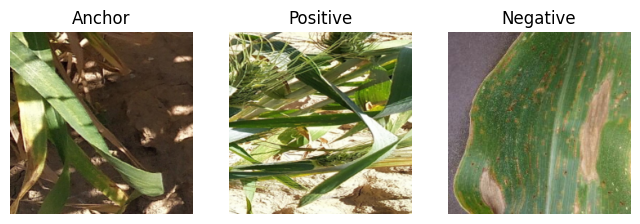

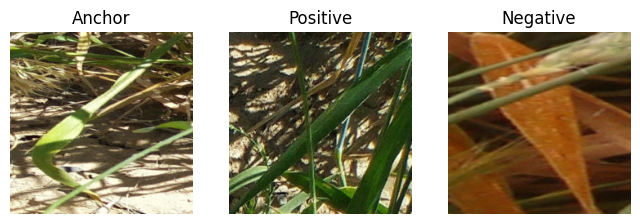

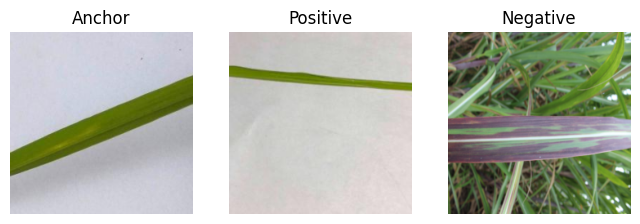

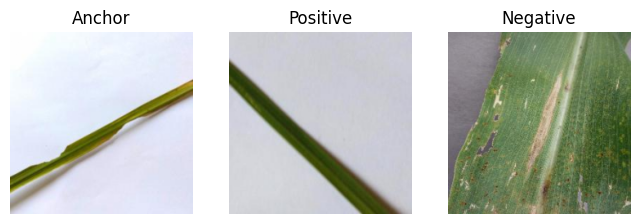

In [103]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Initialize dataset
data_dir = "dataset/test"  # path to your dataset
triplet_ds = SiameseTripletDataset(root=data_dir, transform=transform)

# Wrap in DataLoader
loader = DataLoader(triplet_ds, batch_size=1, shuffle=True)

# Visualize a few triplets
for i, (a, p, n) in enumerate(loader):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    axes[0].imshow(a[0].permute(1,2,0))
    axes[0].set_title("Anchor")
    axes[1].imshow(p[0].permute(1,2,0))
    axes[1].set_title("Positive")
    axes[2].imshow(n[0].permute(1,2,0))
    axes[2].set_title("Negative")
    for ax in axes: ax.axis("off")
    plt.show()
    if i == 3: break  # show 3 triplets only


In [104]:
from torch import amp

class SiameseTrainer:
    def __init__(self, model, device, lr=1e-3, log_interval=20, use_amp=False):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        self.criterion = nn.TripletMarginLoss(margin=1.0, p=2)
        self.scaler = amp.GradScaler("cuda", enabled=use_amp)
        self.use_amp = use_amp
        self.log_interval = log_interval

    def train(self, train_loader, epochs=5):
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (a, p, n) in enumerate(train_loader):
                a, p, n = a.to(self.device), p.to(self.device), n.to(self.device)

                with amp.autocast("cuda", enabled=self.use_amp):
                    emb_a = self.model(a)
                    emb_p = self.model(p)
                    emb_n = self.model(n)
                    loss = self.criterion(emb_a, emb_p, emb_n)

                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += loss.item()

                if (batch_idx + 1) % self.log_interval == 0:
                    print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{epochs}] finished. Avg Loss: {avg_loss:.4f}")

    def save_embeddings(self, dataloader, save_path="embeddings.pt"):
        """Extract embeddings for whole dataset"""
        self.model.eval()
        embeddings, labels = [], []
        with torch.no_grad():
            for imgs, lbls in dataloader:
                imgs = imgs.to(self.device)
                emb = self.model(imgs)
                embeddings.append(emb.cpu())
                labels.append(lbls)
        torch.save({"embeddings": torch.cat(embeddings), "labels": torch.cat(labels)}, save_path)
        print(f"Embeddings saved to {save_path}")


In [24]:
data_dir = "dataset/test"   # path to your dataset (ImageFolder)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

triplet_dataset = SiameseTripletDataset(root=data_dir, transform=transform)
triplet_loader = DataLoader(triplet_dataset, batch_size=16, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_weights = torch.load("Models/siamese_crops_best_model.pth").get("model_state_dict")
model = Siamese(backbone="resnet18", embedding_dim=128, freeze_backbone=True, custom_weights=model_weights)
trainer = SiameseTrainer(model, device, lr=1e-3, use_amp=True)

NameError: name 'SiameseTripletDataset' is not defined

In [ ]:
# trainer.train(triplet_loader, epochs=5)

## Testing Siamese

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch

class Siamese(nn.Module):
    def __init__(self, backbone="resnet18", pretrained=True, embedding_dim=128, freeze_backbone=True):
        super().__init__()
        if backbone == "resnet18":
            base = models.resnet18(pretrained=pretrained)
            in_features = base.fc.in_features
            base.fc = nn.Identity()  # remove final classifier
        else:
            raise NotImplementedError("Only resnet18 implemented here")

        self.backbone = base
        self.embedding = nn.Linear(in_features, embedding_dim)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)        # features
        x = self.embedding(x)       # project to embedding_dim
        x = F.normalize(x, p=2, dim=1)  # L2 normalize
        return x

model = Siamese(backbone="resnet18", embedding_dim=128, freeze_backbone=True)
model.load_state_dict(torch.load(r"Models\siamese_crops_best_model.pth", map_location=device).get('model_state_dict'))
model.to(device)
_ = model.eval()

c:\Users\Gadge\anaconda3\envs\opensora\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gadge\anaconda3\envs\opensora\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\2961490821.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

FileNotFoundError: [Errno 2] No such file or directory: 'Models\\siamese_crops_best_model.pth'

In [108]:
model.eval()
data_dir = "dataset/test" 
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [109]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


In [110]:
embeddings, labels = [], []

with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(test_loader):  # normal ImageFolder loader, not triplet
        imgs = imgs.to(device)
        emb = model(imgs)
        embeddings.append(emb)
        labels.append(lbls)
        if idx % 10 == 0:
            print(f"Processed {(idx + 1) * test_loader.batch_size} images...")
            # break  # Remove this break to process the full dataset

embeddings = torch.cat(embeddings) 
labels = torch.cat(labels).numpy()
print("Embeddings shape:", embeddings.shape)

Processed 128 images...
Processed 1408 images...
Embeddings shape: torch.Size([1342, 128])


In [111]:
print(f"Embeddings extracted. Shape: {embeddings.shape}")
print("Running t-SNE...")

tsne = TSNE(n_components=2, random_state=SEED, method='barnes_hut', verbose=1) # 'barnes_hut' is often faster
emb_2d = tsne.fit_transform(embeddings.to("cpu").numpy())

print("t-SNE complete. Plotting...")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
plt.title("t-SNE of Image Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(num=len(test_dataset.classes)), title="Classes")
# Create a legend
legend1 = plt.legend(*scatter.legend_elements(num=len(test_dataset.classes)), title="Classes")
# Get the current axes instance and add the artist to it
ax = plt.gca()
ax.add_artist(legend1)

plt.show()

Embeddings extracted. Shape: torch.Size([1342, 128])
Running t-SNE...


NameError: name 'SEED' is not defined

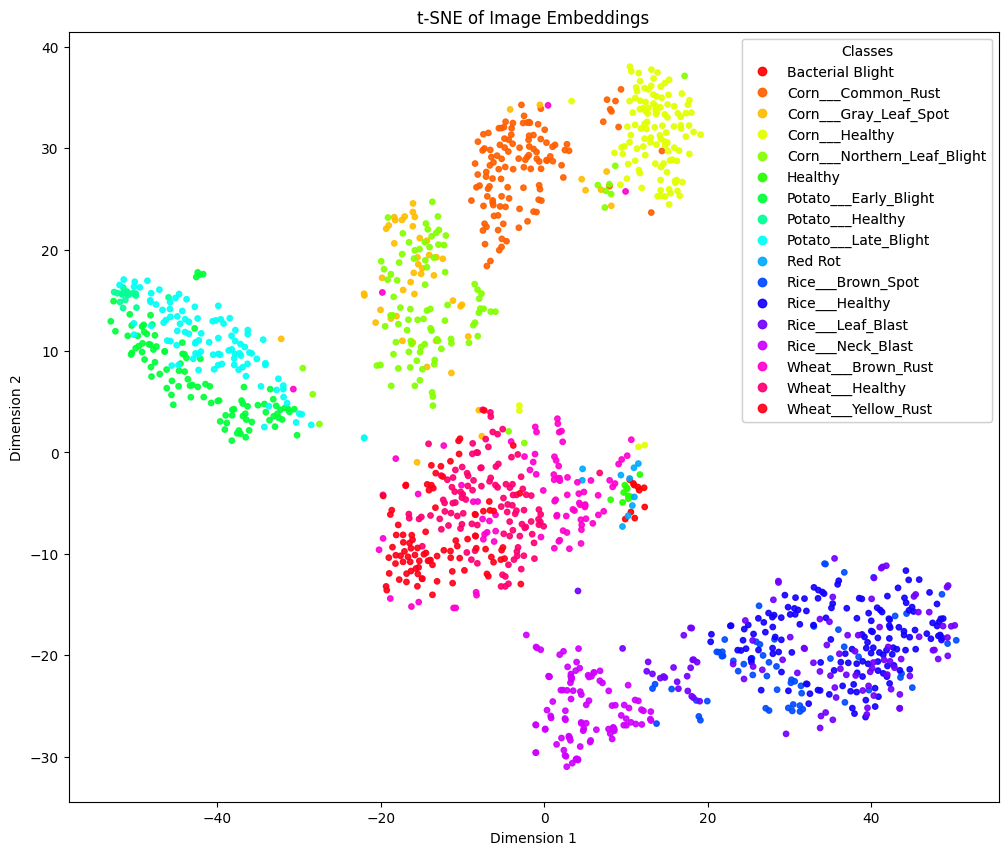

In [ ]:
# --- Plot Results ---
plt.figure(figsize=(12, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap="hsv", s=15, alpha=0.9)
plt.title("t-SNE of Image Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Create a more descriptive legend
# Get the handles from the scatter plot
handles, _ = scatter.legend_elements(num=len(test_dataset.classes))
# Get the actual class names from the ImageFolder dataset
class_names = test_dataset.classes
# Create the legend with proper names
legend1 = plt.legend(handles, class_names, title="Classes")
ax = plt.gca()
ax.add_artist(legend1)

plt.show()

In [27]:
import torch
import os
import torchvision

def identify_model(file_path):
    """Identify model architecture from checkpoint (state_dict or full model)."""
    try:
        checkpoint = torch.load(file_path, map_location="cpu")

        # Case 1: Full model object
        if isinstance(checkpoint, torchvision.models.ResNet):
            layers = [
                len(checkpoint.layer1),
                len(checkpoint.layer2),
                len(checkpoint.layer3),
                len(checkpoint.layer4)
            ]
            if layers == [2, 2, 2, 2]:
                arch = "ResNet18"
            elif layers == [3, 4, 6, 3]:
                arch = "ResNet34"
            elif layers == [3, 4, 23, 3]:
                arch = "ResNet101"
            else:
                arch = f"ResNet (layers={layers})"
        elif isinstance(checkpoint, torchvision.models.EfficientNet):
            arch = "EfficientNet"
        elif isinstance(checkpoint, torchvision.models.MobileNetV2):
            arch = "MobileNetV2"
        elif isinstance(checkpoint, torch.nn.Module):
            arch = f"Custom nn.Module ({checkpoint.__class__.__name__})"
        
        # Case 2: Dictionary with model_state_dict
        elif isinstance(checkpoint, dict):
            if "model_state_dict" in checkpoint:
                state_dict = checkpoint["model_state_dict"]
            else:
                state_dict = checkpoint
            keys = list(state_dict.keys())

            if any("layer1" in k or "fc" in k for k in keys):
                arch = "ResNet"
            elif any("features.0.0" in k and "classifier.1" in k for k in keys):
                arch = "MobileNetV2"
            elif any("features.0.0.0" in k and "classifier.1" in k for k in keys):
                arch = "EfficientNet-B2"
            elif any("embedding" in k for k in keys):
                arch = "Siamese (custom)"
            else:
                arch = "Unknown state_dict"
        else:
            arch = f"Unrecognized type: {type(checkpoint)}"

        print(f"{os.path.basename(file_path)} → {arch}")

    except Exception as e:
        print(f"{file_path}: Error loading ({e})")

# Folder with models
model_dir = "Models"
for fname in os.listdir(model_dir):
    if fname.endswith(".pth"):
        identify_model(os.path.join(model_dir, fname))


C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\4287682284.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location="cpu")


EfficientNetB2_FineTuned.pth → EfficientNet
EfficientNetB2_Frozen.pth → EfficientNet
MobileNet-V2_Finetuned.pth → MobileNetV2
MobileNetV2_Frozen.pth → MobileNetV2
ResNet18_Finetuned.pth → ResNet18
ResNet18_Frozen.pth → ResNet18
ResNet18_Scratch.pth → ResNet18
ResNet18_Siamese_Classifier.pth → Custom nn.Module (Classifier)


In [9]:
# import os

# model_dir = "Models"
# files_to_rename = [
#     "Kaggle_ResNet18_Agri_best_v2.pth",
#     "Kaggle_MobileNetV2_Agri_best.pth",
#     "Kaggle_ResNet18_Agri_best.pth"
# ]

# for fname in files_to_rename:
#     old_path = os.path.join(model_dir, fname)
#     new_name = f"crop_disease_classifier_{fname}"
#     new_path = os.path.join(model_dir, new_name)
#     os.rename(old_path, new_path)
#     print(f"Renamed: {fname} → {new_name}")


Renamed: Kaggle_ResNet18_Agri_best_v2.pth → crop_disease_classifier_Kaggle_ResNet18_Agri_best_v2.pth
Renamed: Kaggle_MobileNetV2_Agri_best.pth → crop_disease_classifier_Kaggle_MobileNetV2_Agri_best.pth
Renamed: Kaggle_ResNet18_Agri_best.pth → crop_disease_classifier_Kaggle_ResNet18_Agri_best.pth


# Testing and Comparing

In [12]:
class Siamese(nn.Module):
    def __init__(self, backbone="resnet18", pretrained=False, embedding_dim=128):
        # `pretrained` should be False as we are loading our own checkpoint
        super().__init__()
        if backbone == "resnet18":
            base = models.resnet18(weights=None) # Load architecture only
            in_features = base.fc.in_features
            base.fc = nn.Identity()
        elif backbone == "resnet50":
            base = models.resnet50(weights=None) # Load architecture only
            in_features = base.fc.in_features
            base.fc = nn.Identity()
        else:
            raise NotImplementedError("Only resnet18 and resnet50 implemented here")

        self.backbone = base
        self.embedding = nn.Linear(in_features, embedding_dim)
        # We don't need to freeze here, as the whole model state is loaded
        # and TestRunner runs in eval mode with no_grad().

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)
        return x

class Classifier(nn.Module):
    def __init__(self, siamese_model, num_classes):
        super().__init__()
        self.siamese_model = siamese_model
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.siamese_model(x)
        x = self.classifier(x)
        return x


In [13]:

import time

class TestRunner:
    """
    TestRunner evaluates a classification model on a test set (folder or DataLoader),
    plots confusion matrix, sample predictions, most-confident incorrect predictions,
    logs everything to TensorBoard and saves per-experiment CSV/JSON results for later comparison.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        test_dir: Optional[str] = None,
        test_loader: Optional[DataLoader] = None,
        device: Optional[torch.device] = None,
        batch_size: int = 64,
        num_workers: int = 4,
        transform: Optional[transforms.Compose] = None,
        log_dir: str = "runs/test",
        results_dir: str = "results/test",
        criterion: Optional[nn.Module] = None,
    ):
        assert (test_dir is not None) or (test_loader is not None), "Pass either test_dir or test_loader"
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.test_dir = test_dir
        self.test_loader = test_loader
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.log_dir = log_dir
        self.results_dir = results_dir
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.writer = SummaryWriter(log_dir=log_dir)

        # default transforms if not provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        os.makedirs(self.results_dir, exist_ok=True)

        # if test_dir given, build DataLoader
        if self.test_loader is None and self.test_dir is not None:
            dataset = datasets.ImageFolder(root=self.test_dir, transform=self.transform)
            self.class_names = dataset.classes
            self.test_loader = DataLoader(dataset, batch_size=self.batch_size,
                                          shuffle=False, num_workers=self.num_workers)
        elif self.test_loader is not None:
            # try to read class names from the dataset if possible
            try:
                self.class_names = self.test_loader.dataset.classes
            except Exception:
                self.class_names = None

        if self.class_names is None:
            # fallback
            self.class_names = [str(i) for i in range(1000)]
            
    def inference_time(self, input_size=(1, 3, 224, 224), warmup=10, runs=100):
        """
        Measure average inference time per image (in milliseconds).
        input_size: tuple, e.g. (1, 3, 224, 224) for batch of 1 RGB image 224x224
        warmup: number of warmup runs before timing
        runs: number of timed runs
        """
        self.model.eval()
        dummy_input = torch.randn(input_size).to(self.device)

        # Warmup
        with torch.no_grad():
            for _ in range(warmup):
                _ = self.model(dummy_input)

        # Timed runs
        times = []
        with torch.no_grad():
            for _ in range(runs):
                start = time.time()
                _ = self.model(dummy_input)
                end = time.time()
                times.append((end - start) * 1000)  # convert to ms

        avg_time = np.mean(times)
        print(f"Average inference time per batch of {input_size[0]}: {avg_time:.2f} ms")
        print(f"Average inference time per image: {avg_time / input_size[0]:.2f} ms")
        return avg_time / input_size[0]
    
    
    def run(self, num_images_grid: int = 8, topk_incorrect: int = 20, save_csv: bool = True):
        """
        Evaluate the model on the test_loader and produce:
          - overall loss & accuracy
          - per-class precision/recall/f1
          - confusion matrix
          - plot sample correct & incorrect predictions (grid)
          - find most-confident incorrect predictions (high predicted probability but wrong)
          - save results as CSV/JSON
          - log figures to TensorBoard
        """
        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        total_correct_top5 = 0
        total_samples = 0

        all_preds = []
        all_labels = []
        all_probs = []  # probability of the predicted class
        all_images = []  # store small subset of images for plotting

        with torch.no_grad():
            loop = tqdm(self.test_loader, desc="Testing")
            for images, labels in loop:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)  # shape (B, C)

                loss = self.criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                # Predictions
                probs = F.softmax(outputs, dim=1)
                confs, preds = torch.max(probs, dim=1)

                # Top 1% accuracy
                total_correct += preds.eq(labels).sum().item()
                total_samples += labels.size(0)
                
                # Top 5% Accuracy
                _, top5_preds = torch.topk(probs, 5, dim=1)
                labels_reshaped = labels.view(-1, 1)
                # Check if the true label is in the top 5 predictions
                total_correct_top5 += torch.sum(top5_preds == labels_reshaped).item()

                all_preds.extend(preds.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())
                all_probs.extend(confs.cpu().numpy().tolist())

                # store a few images for visual grid (as CPU tensors, de-normalized later)
                # store up to num_images_grid*2 images
                # if len(all_images) < num_images_grid * 2: # Remove this condition
                all_images.extend(images.cpu())

        avg_loss = total_loss / total_samples
        accuracy = 100.0 * total_correct / total_samples
        accuracy_top5 = 100.0 * total_correct_top5 / total_samples

        # Classification metrics
        precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, zero_division=0)
        class_report = classification_report(all_labels, all_preds, target_names=self.class_names, zero_division=0, output_dict=True)
        print("\nClassification Report:\n", class_report)

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)

        # Save base results
        results = {
            "num_samples": int(total_samples),
            "loss": float(avg_loss),
            "accuracy": float(accuracy),
            "accuracy_top5": float(accuracy_top5),
            "num_parameters": int(self.num_params),
            "inference_time_ms": self.inference_time(input_size=(1, 3, 224, 224)),
            "per_class": {self.class_names[i]: {
                "precision": float(precision[i]),
                "recall": float(recall[i]),
                "f1": float(f1[i]),
                "support": int(support[i])
            } for i in range(len(self.class_names))}
        }

        # Save json & csv summary
        if save_csv:
            # per-class csv
            perclass_rows = []
            for i, cname in enumerate(self.class_names):
                perclass_rows.append({
                    "class_idx": i,
                    "class_name": cname,
                    "precision": float(precision[i]),
                    "recall": float(recall[i]),
                    "f1": float(f1[i]),
                    "support": int(support[i])
                })
            df_perclass = pd.DataFrame(perclass_rows)
            perclass_csv = os.path.join(self.results_dir, "per_class_metrics.csv")
            df_perclass.to_csv(perclass_csv, index=False)

            # summary csv
            summary_df = pd.DataFrame([{
                "loss": avg_loss,
                "accuracy": accuracy,
                "num_samples": int(total_samples),
            }])
            summary_csv = os.path.join(self.results_dir, "summary.csv")
            summary_df.to_csv(summary_csv, index=False)

            # json
            json_path = os.path.join(self.results_dir, "results.json")
            with open(json_path, "w") as f:
                json.dump(results, f, indent=2)

        # Log scalars to TensorBoard
        self.writer.add_scalar("Test/Loss", avg_loss, 0)
        self.writer.add_scalar("Test/Accuracy", accuracy, 0)

        # Log per-class metrics as text and scalars (macro)
        macro_precision = float(np.nanmean(precision))
        macro_recall = float(np.nanmean(recall))
        macro_f1 = float(np.nanmean(f1))
        self.writer.add_scalar("Test/MacroPrecision", macro_precision, 0)
        self.writer.add_scalar("Test/MacroRecall", macro_recall, 0)
        self.writer.add_scalar("Test/MacroF1", macro_f1, 0)

        # Plot & save confusion matrix figure
        cm_fig = self._plot_confusion_matrix(cm, self.class_names, normalize=False)
        cm_path = os.path.join(self.results_dir, "confusion_matrix.png")
        cm_fig.savefig(cm_path, bbox_inches="tight")
        self.writer.add_figure("ConfusionMatrix", cm_fig)
        plt.close(cm_fig)

        # Plot normalized confusion matrix
        cm_norm_fig = self._plot_confusion_matrix(cm, self.class_names, normalize=True)
        cm_norm_path = os.path.join(self.results_dir, "confusion_matrix_norm.png")
        cm_norm_fig.savefig(cm_norm_path, bbox_inches="tight")
        self.writer.add_figure("ConfusionMatrix_Normalized", cm_norm_fig)
        plt.close(cm_norm_fig)

        # Save a couple of image grids (correct vs incorrect)
        grid_fig = self._plot_prediction_grid(all_images[:num_images_grid], all_labels[:num_images_grid], all_preds[:num_images_grid], self.class_names, num_images=num_images_grid)
        grid_path = os.path.join(self.results_dir, "prediction_grid.png")
        grid_fig.savefig(grid_path, bbox_inches="tight")
        self.writer.add_figure("SamplePredictions", grid_fig)
        plt.close(grid_fig)

        # Find most confident incorrect predictions
        top_incorrect_fig = self._plot_most_confident_incorrects(
            probs=np.array(all_probs),
            preds=np.array(all_preds),
            labels=np.array(all_labels),
            images=all_images,
            class_names=self.class_names,
            topk=topk_incorrect
        )
        if top_incorrect_fig is not None:
            top_incorrect_path = os.path.join(self.results_dir, "most_confident_incorrects.png")
            top_incorrect_fig.savefig(top_incorrect_path, bbox_inches="tight")
            self.writer.add_figure("MostConfidentIncorrects", top_incorrect_fig)
            plt.close(top_incorrect_fig)

        # Save a CSV with overall and per-class metrics for easy aggregation across experiments
        if save_csv:
            out_csv = os.path.join(self.results_dir, "metrics_for_aggregation.csv")
            rows = []
            for i, cname in enumerate(self.class_names):
                rows.append({
                    "experiment": os.path.basename(self.results_dir.rstrip('/')),
                    "class_idx": i,
                    "class_name": cname,
                    "precision": float(precision[i]),
                    "recall": float(recall[i]),
                    "f1": float(f1[i]),
                    "support": int(support[i]),
                    "overall_accuracy": accuracy,
                    "overall_accuracy_top5": accuracy_top5,
                    "overall_loss": avg_loss
                })
            pd.DataFrame(rows).to_csv(out_csv, index=False)

        np.save(os.path.join(self.results_dir, "predictions.npy"), np.array(all_preds))
        np.save(os.path.join(self.results_dir, "labels.npy"), np.array(all_labels))
        print(f"\nTest results saved to {self.results_dir}")
        print(f"Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")
        return results

    def _plot_confusion_matrix(self, cm: np.ndarray, class_names: List[str], normalize: bool = False):
        """
        Return a matplotlib figure for the confusion matrix.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        if normalize:
            cm_sum = cm.sum(axis=1)[:, np.newaxis]
            cm_plot = np.divide(cm, cm_sum, where=cm_sum != 0)
            sns.heatmap(cm_plot, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_title("Normalized Confusion Matrix")
        else:
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_title("Confusion Matrix (Counts)")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        return fig

    def _denormalize(self, tensor_img: torch.Tensor):
        """Convert a normalized image tensor back to [0,1] numpy image for plotting."""
        img = tensor_img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)
        return img.permute(1, 2, 0).numpy()

    def _plot_prediction_grid(self, all_images: List[torch.Tensor], all_labels: List[int], all_preds: List[int],
                              class_names: List[str], num_images: int = 8):
        """
        Plot a grid of images showing predicted vs true label (a mix of correct + incorrect).
        """
        # Prepare a small selection
        n = min(len(all_images), num_images)
        fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
        for i in range(n):
            ax = axes[i] if n > 1 else axes
            img = self._denormalize(all_images[i])
            true = class_names[all_labels[i]]
            pred = class_names[all_preds[i]]
            ax.imshow(img)
            ax.set_title(f"T:{true}\nP:{pred}")
            ax.axis("off")
        plt.tight_layout()
        return fig

    def _plot_most_confident_incorrects(self, probs: np.ndarray, preds: np.ndarray, labels: np.ndarray,
                                        images: List[torch.Tensor], class_names: List[str], topk: int = 20):
        """
        Identify incorrect predictions where model was most confident, and plot topk of them.
        probs: predicted class probability for each item (same length as preds)
        """
        incorrect_mask = preds != labels
        if incorrect_mask.sum() == 0:
            print("No incorrect predictions to show.")
            return None

        incorrect_probs = probs[incorrect_mask]
        incorrect_indices = np.where(incorrect_mask)[0]
        # sort by descending predicted probability
        order = np.argsort(-incorrect_probs)
        topk_idx = incorrect_indices[order][:topk]

        n = len(topk_idx)
        cols = 5
        rows = max(1, int(np.ceil(n / cols)))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = axes.flatten()
        for i, idx in enumerate(topk_idx):
            ax = axes[i]
            img = self._denormalize(images[idx])
            true = class_names[labels[idx]]
            pred = class_names[preds[idx]]
            conf = probs[idx]
            ax.imshow(img)
            ax.set_title(f"P:{pred} ({conf:.2f})\nT:{true}")
            ax.axis("off")
        # hide extra axes
        for j in range(n, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        return fig

  
def compare_runs(results_root: str, out_fig: Optional[str] = None):
    """
    Aggregate all 'metrics_for_aggregation.csv' under results_root
    and create a comparison table/plot for overall accuracy & per-class f1 across experiments.

    results_root: folder containing subfolders for each experiment (each should have metrics_for_aggregation.csv)
    """
    csv_paths = list(Path(results_root).rglob("metrics_for_aggregation.csv"))
    if len(csv_paths) == 0:
        raise FileNotFoundError("No metrics_for_aggregation.csv files found under " + str(results_root))

    dfs = []
    for p in csv_paths:
        df = pd.read_csv(p)
        # add experiment name if missing
        if 'experiment' not in df.columns:
            df['experiment'] = p.parent.name
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)
    # overall accuracy per experiment: take first row's overall_accuracy (they're same per file)
    overall = all_df.groupby('experiment')[['overall_accuracy', 'overall_loss']].mean().reset_index()

    # Quick barplot: overall_accuracy
    
    fig, ax = plt.subplots(figsize=(10, 8))  # taller instead of wider
    sns.barplot(
        data=overall.sort_values('overall_accuracy', ascending=True),  # sort ascending for horizontal bars
        y='experiment', x='overall_accuracy', ax=ax
    )
    ax.set_xlabel("Accuracy (%)")
    ax.set_ylabel("Experiment")
    plt.tight_layout()
    plt.title("Overall Test Accuracy by Experiment")
    if out_fig:
        fig.savefig(out_fig, bbox_inches="tight")
    return all_df, fig

In [129]:
# import os

# def rename_folders(base_dir):
#     """
#     Renames specific folders within train, val, and test directories
#     by adding a 'Sugarcane_' prefix.
#     """
#     if not os.path.isdir(base_dir):
#         raise ValueError(f"Base directory '{base_dir}' does not exist.")

#     # Define the splits (subdirectories) to process
#     splits = ["train", "val", "test"]
    
#     # Define the folder names to be changed
#     folders_to_rename = ["Healthy", "Bacterial Blight", "Red Rot"]
    
#     # Loop through each split (train, val, test)
#     for split in splits:
#         split_path = os.path.join(base_dir, split)
        
#         # Check if the split directory (e.g., 'dataset/train') exists
#         if not os.path.isdir(split_path):
#             continue
            
#         print(f"Processing directory: {split_path}")
        
#         # Loop through each folder name we want to rename
#         for folder_name in folders_to_rename:
#             old_path = os.path.join(split_path, folder_name)
#             new_name = f"Sugarcane__{folder_name}"
#             new_path = os.path.join(split_path, new_name)
            
#             # Check if the source folder (e.g., 'dataset/train/Health') exists
#             if os.path.isdir(old_path):
#                 try:
#                     os.rename(old_path, new_path)
#                     print(f"  - Renamed '{folder_name}' to '{new_name}'")
#                 except OSError as e:
#                     print(f"  - Error renaming '{folder_name}': {e}")

#     print("\nRenaming complete.")

# rename_folders('dataset')

In [14]:
from torchvision import datasets

test_data = datasets.ImageFolder("dataset/test")
print("Found classes:", test_data.classes)
print("Total images:", len(test_data))

Found classes: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Sugarcane__Bacterial Blight', 'Sugarcane__Healthy', 'Sugarcane__Red Rot', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Total images: 1342


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
path = r"c:\Users\Gadge\Education\BSBI\Robotics and Computer Vision\Models\siamese_classifier_full.pth"

model_name = os.path.splitext(os.path.basename(path))[0]
model = torch.load(path, map_location=device, weights_only=False)
tester = TestRunner(
    model,
    test_dir="dataset/test",
    device=device,
    log_dir=f"runs/{model_name}_test",
    results_dir=f"results/{model_name}_results",
    batch_size=64,
    num_workers=os.cpu_count() // 2
)
tester.run(num_images_grid=8, topk_incorrect=5)

Testing: 100%|██████████| 21/21 [01:44<00:00,  4.96s/it]



Classification Report:
 {'Corn___Common_Rust': {'precision': 0.8805970149253731, 'recall': 0.9833333333333333, 'f1-score': 0.9291338582677166, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.8931297709923665, 'recall': 1.0, 'f1-score': 0.9435483870967742, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.6870229007633588, 'recall': 0.9090909090909091, 'f1-score': 0.7826086956521738, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.8878504672897196, 'recall': 0.95, 'f1-score': 0.9178743961352657, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.8073394495412844, 'recall': 0.88, 'f1-score': 0.8421052631578948, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.4901960784313725

{'num_samples': 1342,
 'loss': 1.5694376473632903,
 'accuracy': 75.78241430700447,
 'accuracy_top5': 96.05067064083458,
 'num_parameters': 2193,
 'inference_time_ms': 7.614345550537109,
 'per_class': {'Corn___Common_Rust': {'precision': 0.8805970149253731,
   'recall': 0.9833333333333333,
   'f1': 0.9291338582677166,
   'support': 120},
  'Corn___Gray_Leaf_Spot': {'precision': 0.0,
   'recall': 0.0,
   'f1': 0.0,
   'support': 52},
  'Corn___Healthy': {'precision': 0.8931297709923665,
   'recall': 1.0,
   'f1': 0.9435483870967742,
   'support': 117},
  'Corn___Northern_Leaf_Blight': {'precision': 0.6870229007633588,
   'recall': 0.9090909090909091,
   'f1': 0.7826086956521738,
   'support': 99},
  'Potato___Early_Blight': {'precision': 0.8878504672897196,
   'recall': 0.95,
   'f1': 0.9178743961352657,
   'support': 100},
  'Potato___Healthy': {'precision': 0.0,
   'recall': 0.0,
   'f1': 0.0,
   'support': 16},
  'Potato___Late_Blight': {'precision': 0.8073394495412844,
   'recall': 0

In [29]:
from tqdm import tqdm
all_models = [os.path.join("Models", m) for m in os.listdir("Models") if m.endswith(".pth")]
for path in all_models:
    print(f"\nEvaluating model: {os.path.basename(path)}")
    model_name = os.path.splitext(os.path.basename(path))[0]
    model = torch.load(path, map_location=device, weights_only=False)
    tester = TestRunner(
        model,
        test_dir="dataset/test",
        device=device,
        log_dir=f"runs/{model_name}_test",
        results_dir=f"results/{model_name}_results",
        batch_size=64,
        num_workers=os.cpu_count() // 2
    )
    tester.run(num_images_grid=8, topk_incorrect=5)


Evaluating model: EfficientNetB2_FineTuned.pth


C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.7628205128205128, 'recall': 0.9916666666666667, 'f1-score': 0.8623188405797101, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.8888888888888888, 'recall': 0.15384615384615385, 'f1-score': 0.2622950819672132, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.9913793103448276, 'recall': 0.9829059829059829, 'f1-score': 0.9871244635193134, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.7264150943396226, 'recall': 0.7777777777777778, 'f1-score': 0.7512195121951221, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.978021978021978, 'recall': 0.89, 'f1-score': 0.9319371727748691, 'support': 100.0}, 'Potato___Healthy': {'precision': 1.0, 'recall': 0.1875, 'f1-score': 0.3157894736842105, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.8521739130434782, 'recall': 0.98, 'f1-score': 0.9116279069767441, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.5172413793103449, 'recall

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.008403361344537815, 'recall': 0.010101010101010102, 'f1-score': 0.009174311926605505, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 150.0}, 'Rice___Leaf_Blast': {'precision': 0.08333333333333333, 'recall': 0.010101010101010102, 'f1-s

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)



Test results saved to results/EfficientNetB2_Frozen_results
Accuracy: 21.76%, Loss: 11.0733

Evaluating model: MobileNet-V2_Finetuned.pth


Testing: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]



Classification Report:
 {'Corn___Common_Rust': {'precision': 0.6835443037974683, 'recall': 0.9, 'f1-score': 0.776978417266187, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.9047619047619048, 'recall': 0.7307692307692307, 'f1-score': 0.8085106382978723, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.9914529914529915, 'recall': 0.9914529914529915, 'f1-score': 0.9914529914529915, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.811965811965812, 'recall': 0.9595959595959596, 'f1-score': 0.8796296296296297, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.9801980198019802, 'recall': 0.99, 'f1-score': 0.9850746268656716, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.888888888888889, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 1.0, 'recall': 0.92, 'f1-score': 0.9583333333333334, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.68, 'recall': 0.5483870967741935, 'f1-score': 0.6071428571428

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)



Test results saved to results/MobileNet-V2_Finetuned_results
Accuracy: 87.63%, Loss: 0.4333

Evaluating model: MobileNetV2_Frozen.pth


Testing: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it]



Classification Report:
 {'Corn___Common_Rust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.009174311926605505, 'recall': 0.019230769230769232, 'f1-score': 0.012422360248447204, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.01680672268907563, 'recall': 0.020202020202020204, 'f1-score': 0.01834862385321101, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.011235955056179775, 'recall': 0.01, 'f1-score': 0.010582010582010581, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 150.0}, 'Rice___L

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.9915966386554622, 'recall': 0.9833333333333333, 'f1-score': 0.9874476987447698, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.94, 'recall': 0.9038461538461539, 'f1-score': 0.9215686274509804, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.9831932773109243, 'recall': 1.0, 'f1-score': 0.9915254237288135, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.9583333333333334, 'recall': 0.9292929292929293, 'f1-score': 0.9435897435897437, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 1.0, 'recall': 0.99, 'f1-score': 0.9949748743718593, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.8421052631578947, 'recall': 1.0, 'f1-score': 0.9142857142857143, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.9896907216494846, 'recall': 0.96, 'f1-score': 0.9746192893401014, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.7647058823529411, 'recall': 0.41935483870967744, 'f1-scor

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.008333333333333333, 'recall': 0.010101010101010102, 'f1-score': 0.0091324200913242, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.06363636363636363, 'recall': 0.07, 'f1-score': 0.06666666666666667, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 150.0}, 'Rice___Leaf_Blast': {'precision': 0.0, 'recall': 0.0, 'f1-sco

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.053515215110178385, 'recall': 0.9807692307692307, 'f1-score': 0.10149253731343283, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 150.0}, 'Rice___Leaf_Blast': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 99.0}, 'Rice_

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\3098964418.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)
Testing: 100%|


Classification Report:
 {'Corn___Common_Rust': {'precision': 0.8805970149253731, 'recall': 0.9833333333333333, 'f1-score': 0.9291338582677166, 'support': 120.0}, 'Corn___Gray_Leaf_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 52.0}, 'Corn___Healthy': {'precision': 0.8931297709923665, 'recall': 1.0, 'f1-score': 0.9435483870967742, 'support': 117.0}, 'Corn___Northern_Leaf_Blight': {'precision': 0.6870229007633588, 'recall': 0.9090909090909091, 'f1-score': 0.7826086956521738, 'support': 99.0}, 'Potato___Early_Blight': {'precision': 0.8878504672897196, 'recall': 0.95, 'f1-score': 0.9178743961352657, 'support': 100.0}, 'Potato___Healthy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16.0}, 'Potato___Late_Blight': {'precision': 0.8073394495412844, 'recall': 0.88, 'f1-score': 0.8421052631578948, 'support': 100.0}, 'Rice___Brown_Spot': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62.0}, 'Rice___Healthy': {'precision': 0.4901960784313725

(                              experiment  class_idx                   class_name  precision  recall     f1  support  overall_accuracy  overall_accuracy_top5  overall_loss
 0       EfficientNetB2_FineTuned_results          0           Corn___Common_Rust      0.763   0.992  0.862      120            83.532                 99.553         0.477
 1       EfficientNetB2_FineTuned_results          1        Corn___Gray_Leaf_Spot      0.889   0.154  0.262       52            83.532                 99.553         0.477
 2       EfficientNetB2_FineTuned_results          2               Corn___Healthy      0.991   0.983  0.987      117            83.532                 99.553         0.477
 3       EfficientNetB2_FineTuned_results          3  Corn___Northern_Leaf_Blight      0.726   0.778  0.751       99            83.532                 99.553         0.477
 4       EfficientNetB2_FineTuned_results          4        Potato___Early_Blight      0.978   0.890  0.932      100            83.532      

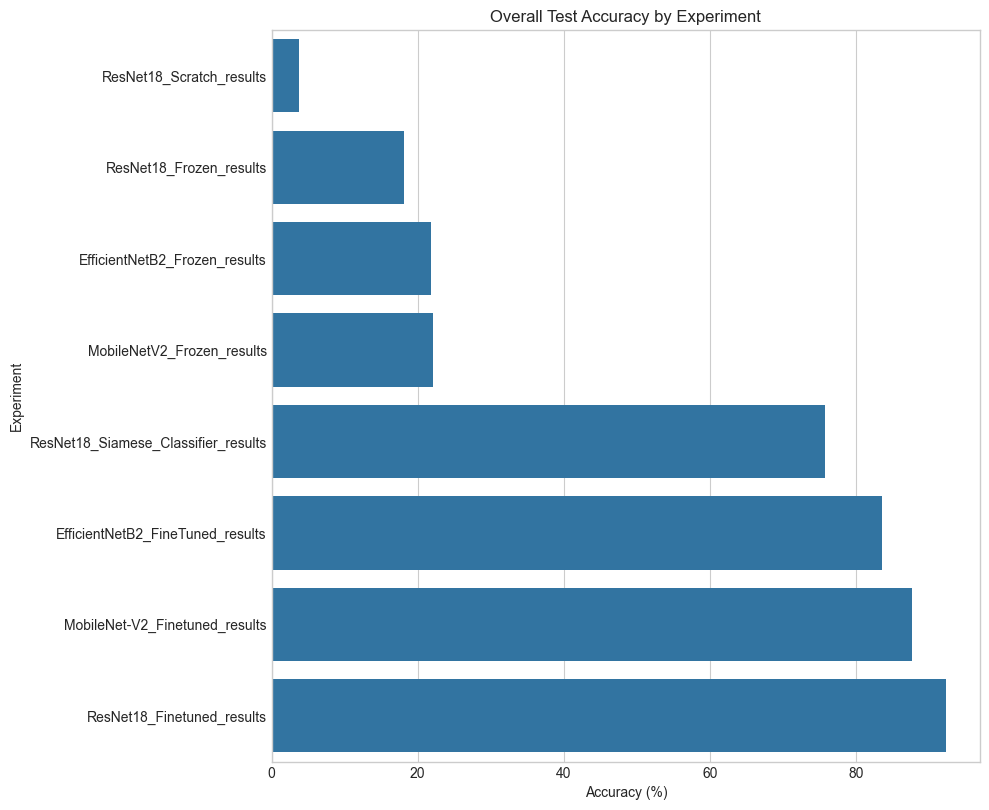

In [30]:
compare_runs("results", out_fig="results/summary_comparison.png")

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix


In [32]:
def load_all_results(results_root: str) -> pd.DataFrame:
    """Load and combine all 'metrics_for_aggregation.csv' files."""
    csv_paths = list(Path(results_root).rglob("metrics_for_aggregation.csv"))
    if not csv_paths:
        raise FileNotFoundError(f"No 'metrics_for_aggregation.csv' files found in {results_root}")
    
    all_dfs = [pd.read_csv(p) for p in csv_paths]
    return pd.concat(all_dfs, ignore_index=True)

def plot_leaderboard(df: pd.DataFrame):
    """Plot a comprehensive leaderboard of model performance."""
    # Aggregate overall metrics. Need to get inference time and params too.
    # This assumes these values are available or can be added to the summary CSV.
    # For now, we focus on accuracy.
    overall_metrics = df.groupby('experiment')[['overall_accuracy', 'overall_accuracy_top5']].mean().reset_index()
    
    df_melted = overall_metrics.melt(
        id_vars='experiment', 
        value_vars=['overall_accuracy', 'overall_accuracy_top5'],
        var_name='Metric', 
        value_name='Accuracy'
    )
    df_melted['Metric'] = df_melted['Metric'].replace({
        'overall_accuracy': 'Top-1 Accuracy',
        'overall_accuracy_top5': 'Top-5 Accuracy'
    })
    
    print(df_melted)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=df_melted, y='experiment', x='Accuracy', hue='Metric', ax=ax)
    
    ax.set_title('Model Performance Leaderboard', fontsize=16, weight='bold')
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_ylabel('Experiment', fontsize=12)
    ax.legend(title='Metric')
    
    # Add value labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=10, padding=3)
        
    plt.tight_layout()
    return fig

def plot_f1_heatmap(df: pd.DataFrame):
    """Plot a heatmap of per-class F1-scores across experiments."""
    f1_pivot = df.pivot_table(index='class_name', columns='experiment', values='f1')
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(f1_pivot, annot=True, fmt=".2f", cmap="viridis", ax=ax, linewidths=.5)
    
    ax.set_title('Per-Class F1-Score Comparison', fontsize=16, weight='bold')
    ax.set_xlabel('Experiment', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    return fig

def plot_hardest_classes(results_root: str, top_n: int = 5):
    """Identify and plot the classes with the most misclassifications for each model."""
    exp_dirs = [d for d in Path(results_root).iterdir() if d.is_dir()]
    
    fig, axes = plt.subplots(len(exp_dirs), 1, figsize=(12, len(exp_dirs) * 5), squeeze=False)
    axes = axes.flatten()

    for i, exp_dir in enumerate(exp_dirs):
        preds_path = exp_dir / "predictions.npy"
        labels_path = exp_dir / "labels.npy"
        metrics_path = exp_dir / "metrics_for_aggregation.csv"
        
        if not all([preds_path.exists(), labels_path.exists(), metrics_path.exists()]):
            continue
            
        preds = np.load(preds_path)
        labels = np.load(labels_path)
        class_names = pd.read_csv(metrics_path)['class_name'].unique()
        
        cm = confusion_matrix(labels, preds)
        # Errors are non-diagonal elements
        errors_per_class = cm.sum(axis=1) - np.diag(cm)
        
        hardest_indices = np.argsort(-errors_per_class)[:top_n]
        
        ax = axes[i]
        sns.barplot(x=[class_names[j] for j in hardest_indices], y=errors_per_class[hardest_indices], ax=ax, palette='Reds_r')
        ax.set_title(f"Top {top_n} Hardest Classes for: {exp_dir.name}", fontsize=14, weight='bold')
        ax.set_ylabel('Number of Misclassifications')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

In [33]:
RESULTS_ROOT = "results" # Directory containing all your experiment folders
PLOTS_DIR = "final_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Load all data
all_data_df = load_all_results(RESULTS_ROOT)
all_data_df.head()

,experiment,class_idx,class_name,precision,recall,f1,support,overall_accuracy,overall_accuracy_top5,overall_loss
0,EfficientNetB2_FineTuned_results,0,Corn___Common_Rust,0.763,0.992,0.862,120,83.532,99.553,0.477
1,EfficientNetB2_FineTuned_results,1,Corn___Gray_Leaf_Spot,0.889,0.154,0.262,52,83.532,99.553,0.477
2,EfficientNetB2_FineTuned_results,2,Corn___Healthy,0.991,0.983,0.987,117,83.532,99.553,0.477
3,EfficientNetB2_FineTuned_results,3,Corn___Northern_Leaf_Blight,0.726,0.778,0.751,99,83.532,99.553,0.477
4,EfficientNetB2_FineTuned_results,4,Potato___Early_Blight,0.978,0.890,0.932,100,83.532,99.553,0.477


In [34]:
all_data_df.to_csv(os.path.join(RESULTS_ROOT, "all_models_combined_metrics.csv"), index=False)

In [35]:
import json
def create_summary_table(results_root: str) -> pd.DataFrame:
    """
    Scans a directory for experiment results, aggregates them, and
    creates a clean, formatted pandas DataFrame for comparison.

    Args:
        results_root: The main folder containing all individual experiment
                      result folders (e.g., 'results/').

    Returns:
        A pandas DataFrame summarizing the performance of all models.
    """
    # Use rglob to find all 'results.json' files in subdirectories
    json_paths = list(Path(results_root).rglob("results.json"))
    
    if not json_paths:
        print(f"Warning: No 'results.json' files found in any subdirectories of '{results_root}'.")
        print("Please ensure you have run the TestRunner for your experiments.")
        return pd.DataFrame()

    all_results_data = []
    for path in json_paths:
        with open(path, 'r') as f:
            data = json.load(f)
        experiment_name = path.parent.name.replace("_results", "")        
        per_class_metrics = data.get("per_class", {}).values()
        if per_class_metrics:
            macro_f1 = np.mean([m.get("f1", 0) for m in per_class_metrics])
            macro_precision = np.mean([m.get("precision", 0) for m in per_class_metrics])
            macro_recall = np.mean([m.get("recall", 0) for m in per_class_metrics])
        else:
            macro_f1, macro_precision, macro_recall = 0, 0, 0
        # Model size in MB (assuming float32 parameters)
        num_params = data.get("num_parameters", 0)
        model_size_mb = (num_params * 4) / (1024**2)

        all_results_data.append({
            "model": experiment_name,
            "f1_score": macro_f1,
            "precision": macro_precision,
            "recall": macro_recall,
            "top1_accuracy": data.get("accuracy", 0) / 100.0,
            "top5_accuracy": data.get("accuracy_top5", 0) / 100.0,
            "inference_time_ms": data.get("inference_time_ms", 0),
            "model_size_mb": model_size_mb
        })
        
    summary_df = pd.DataFrame(all_results_data)
    summary_df = summary_df.sort_values(by="top1_accuracy", ascending=False).reset_index(drop=True)
    
    return summary_df


RESULTS_DIR = "results"
comparison_table = create_summary_table(RESULTS_DIR)

if not comparison_table.empty:
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.precision', 5)
    
    print("--- Model Performance Comparison Summary ---")
    print(comparison_table)
    output_csv_path = os.path.join(RESULTS_DIR, "comparison_summary.csv")
    comparison_table.to_csv(output_csv_path, index=False)
    print(f"\nSummary table saved to: {output_csv_path}")

--- Model Performance Comparison Summary ---
                         model  f1_score  precision   recall  top1_accuracy  top5_accuracy  inference_time_ms  model_size_mb
0           ResNet18_Finetuned   0.90090    0.91110  0.90059        0.92325        0.99925            9.59843       32.05280
1       MobileNet-V2_Finetuned   0.84454    0.85652  0.84822        0.87630        0.99925            5.90022        8.56647
2     EfficientNetB2_FineTuned   0.75836    0.81440  0.77465        0.83532        0.99553           76.96422        1.99274
3  ResNet18_Siamese_Classifier   0.50610    0.50832  0.54810        0.75782        0.96051           10.76120        0.00837
4           MobileNetV2_Frozen   0.14604    0.12603  0.17731        0.22131        0.37630           26.27820        8.56647
5        EfficientNetB2_Frozen   0.15979    0.15701  0.17303        0.21759        0.47839           29.21129       29.46833
6              ResNet18_Frozen   0.14249    0.15401  0.14488        0.18107     

In [48]:
from collections import OrderedDict
resnet18_model = torch.load(
    r"Models\ResNet18_Finetuned.pth",
    weights_only=False, map_location=torch.device('cpu')
)

dummy_input = torch.randn(1, 3, 224, 224)

layer_info = []

def register_hook(module, name):
    def hook(module, input, output):
        if isinstance(output, torch.Tensor):
            out_shape = list(output.shape)
            resolution = f"{out_shape[2]} × {out_shape[3]}" if len(out_shape) == 4 else "-"
            channels = out_shape[1] if len(out_shape) == 4 else out_shape[-1]
            layer_info.append({
                "Layer": name,
                "Operator": module.__class__.__name__,
                "Resolution": resolution,
                "Channels": channels,
                "Params": sum(p.numel() for p in module.parameters() if p.requires_grad)
            })
    return hook

# Register hooks for conv, bn, relu, pooling, fc
for name, module in resnet18_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d, nn.ReLU, nn.MaxPool2d, nn.AdaptiveAvgPool2d)):
        module.register_forward_hook(register_hook(module, name))

# Forward pass
_ = resnet18_model(dummy_input)

# Build DataFrame
df = pd.DataFrame(layer_info)
print(df)
df.to_csv(
    os.path.join(RESULTS_DIR, "ResNet18_Finetuned_layer_info.csv"),
    index=False
)

# Optional: group into "stages" like papers
stage_table = df.groupby(["Resolution", "Channels", "Operator"]).size().reset_index(name="No. of Layers")
stage_table.insert(0, "Stage", range(1, len(stage_table)+1))
print("\n--- Stage Summary ---\n")
print(stage_table)
stage_table.to_csv(
    os.path.join(RESULTS_DIR, "ResNet18_Finetuned_layer_summary.csv"),
    index=False
)

                    Layer           Operator Resolution  Channels   Params
0                   conv1             Conv2d  112 × 112        64        0
1                     bn1        BatchNorm2d  112 × 112        64        0
2                    relu               ReLU  112 × 112        64        0
3                 maxpool          MaxPool2d    56 × 56        64        0
4          layer1.0.conv1             Conv2d    56 × 56        64        0
5            layer1.0.bn1        BatchNorm2d    56 × 56        64        0
6           layer1.0.relu               ReLU    56 × 56        64        0
7          layer1.0.conv2             Conv2d    56 × 56        64        0
8            layer1.0.bn2        BatchNorm2d    56 × 56        64        0
9           layer1.0.relu               ReLU    56 × 56        64        0
10         layer1.1.conv1             Conv2d    56 × 56        64        0
11           layer1.1.bn1        BatchNorm2d    56 × 56        64        0
12          layer1.1.relu

--- Model Performance Comparison Summary ---
                         model  f1_score  precision  recall  top1_accuracy  top5_accuracy  inference_time_ms  model_size_mb  top1_accuracy_pct
0           ResNet18_Finetuned     0.901      0.911   0.901          0.923          0.999              9.598         32.053               92.3
1       MobileNet-V2_Finetuned     0.845      0.857   0.848          0.876          0.999              5.900          8.566               87.6
2     EfficientNetB2_FineTuned     0.758      0.814   0.775          0.835          0.996             76.964          1.993               83.5
3  ResNet18_Siamese_Classifier     0.506      0.508   0.548          0.758          0.961             10.761          0.008               75.8
4           MobileNetV2_Frozen     0.146      0.126   0.177          0.221          0.376             26.278          8.566               22.1
5        EfficientNetB2_Frozen     0.160      0.157   0.173          0.218          0.478        

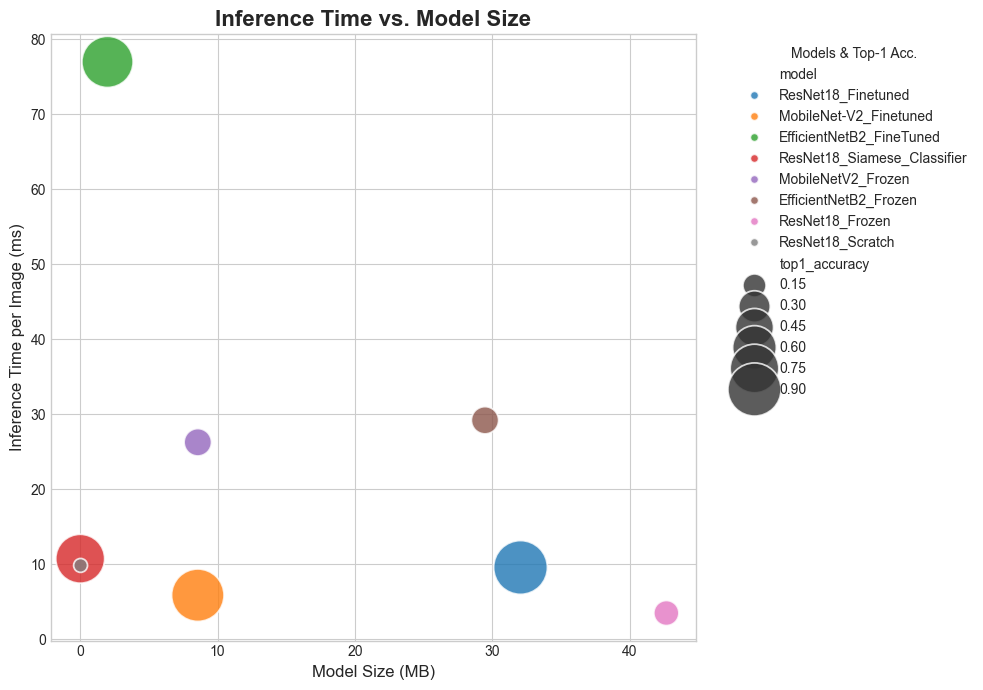

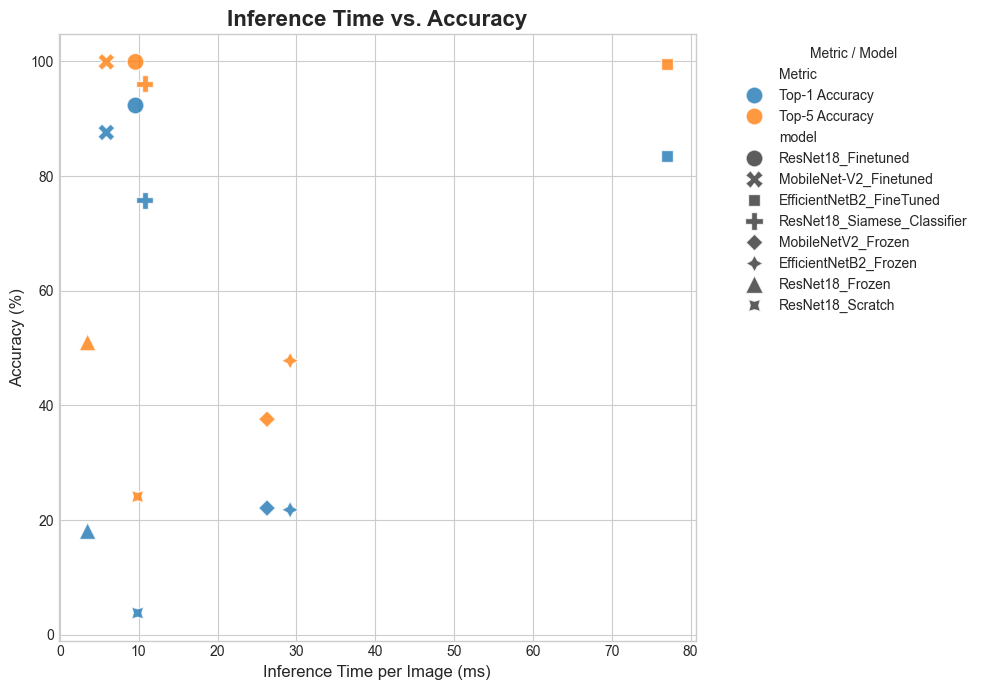

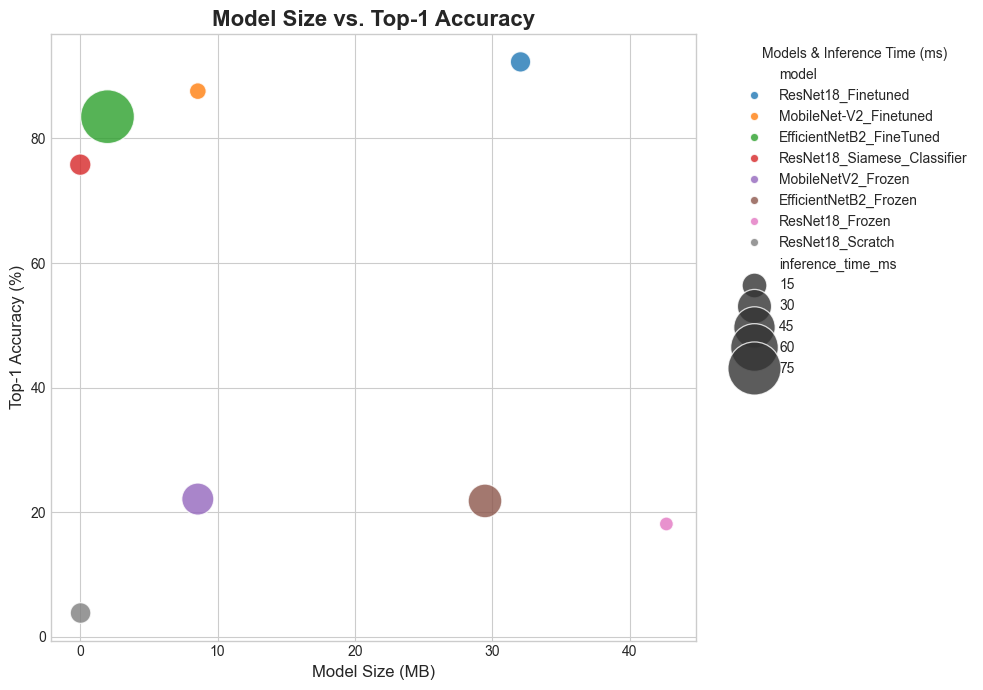

In [49]:

def plot_time_vs_size(df: pd.DataFrame):
    """Plots a comparison of inference time vs. model size."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(
        data=df,
        x='model_size_mb',
        y='inference_time_ms',
        hue='model',
        size='top1_accuracy',
        sizes=(100, 1500),
        alpha=0.8,
        ax=ax
    )
    ax.set_title('Inference Time vs. Model Size', fontsize=16, weight='bold')
    ax.set_xlabel('Model Size (MB)', fontsize=12)
    ax.set_ylabel('Inference Time per Image (ms)', fontsize=12)
    ax.legend(title='Models & Top-1 Acc.', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig

def plot_time_vs_accuracy(df: pd.DataFrame):
    """Plots a comparison of inference time vs. Top-1 and Top-5 accuracy."""
    df_melted = df.melt(
        id_vars=['model', 'inference_time_ms'],
        value_vars=['top1_accuracy', 'top5_accuracy'],
        var_name='Metric',
        value_name='Accuracy'
    )
    df_melted['Accuracy'] *= 100 # Convert back to percentage for plotting
    df_melted['Metric'] = df_melted['Metric'].replace({
        'top1_accuracy': 'Top-1 Accuracy',
        'top5_accuracy': 'Top-5 Accuracy'
    })

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(
        data=df_melted,
        x='inference_time_ms',
        y='Accuracy',
        hue='Metric',
        style='model',
        s=150, # Marker size
        alpha=0.8,
        ax=ax
    )
    ax.set_title('Inference Time vs. Accuracy', fontsize=16, weight='bold')
    ax.set_xlabel('Inference Time per Image (ms)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.legend(title='Metric / Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig

def plot_size_vs_accuracy(df: pd.DataFrame):
    """Plots a comparison of model size vs. Top-1 accuracy."""
    df['top1_accuracy_pct'] = df['top1_accuracy'] * 100
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(
        data=df,
        x='model_size_mb',
        y='top1_accuracy_pct',
        hue='model',
        size='inference_time_ms',
        sizes=(100, 1500),
        alpha=0.8,
        ax=ax
    )
    ax.set_title('Model Size vs. Top-1 Accuracy', fontsize=16, weight='bold')
    ax.set_xlabel('Model Size (MB)', fontsize=12)
    ax.set_ylabel('Top-1 Accuracy (%)', fontsize=12)
    ax.legend(title='Models & Inference Time (ms)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig


if not comparison_table.empty:
    # Round numerical columns for cleaner output
    cols_to_round = [
        "f1_score", "precision", "recall", 
        "top1_accuracy", "top5_accuracy", 
        "inference_time_ms", "model_size_mb"
    ]
    for col in cols_to_round:
        if col in comparison_table.columns:
            comparison_table[col] = comparison_table[col].round(3)

    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', 10)
    pd.set_option('display.precision', 3)
    
    print("--- Model Performance Comparison Summary ---")
    print(comparison_table)
    
    output_csv_path = os.path.join(RESULTS_DIR, "comparison_summary.csv")
    comparison_table.to_csv(output_csv_path, index=False)
    print(f"\nSummary table saved to: {output_csv_path}")

    # --- Generate and Save New Plots ---
    print("\nGenerating comparison plots...")
    
    # 1. Time vs. Size
    fig1 = plot_time_vs_size(comparison_table)
    fig1.savefig(os.path.join(PLOTS_DIR, "4_time_vs_size.png"), dpi=300, bbox_inches='tight')
    
    # 2. Time vs. Accuracy
    fig2 = plot_time_vs_accuracy(comparison_table)
    fig2.savefig(os.path.join(PLOTS_DIR, "5_time_vs_accuracy.png"), dpi=300, bbox_inches='tight')
    
    # 3. Size vs. Accuracy
    fig3 = plot_size_vs_accuracy(comparison_table)
    fig3.savefig(os.path.join(PLOTS_DIR, "6_size_vs_accuracy.png"), dpi=300, bbox_inches='tight')

    print(f"Comparison plots saved to '{PLOTS_DIR}' directory.")
    plt.show()


                             experiment          Metric  Accuracy
0      EfficientNetB2_FineTuned_results  Top-1 Accuracy    83.532
1         EfficientNetB2_Frozen_results  Top-1 Accuracy    21.759
2        MobileNet-V2_Finetuned_results  Top-1 Accuracy    87.630
3            MobileNetV2_Frozen_results  Top-1 Accuracy    22.131
4            ResNet18_Finetuned_results  Top-1 Accuracy    92.325
5               ResNet18_Frozen_results  Top-1 Accuracy    18.107
6              ResNet18_Scratch_results  Top-1 Accuracy     3.800
7   ResNet18_Siamese_Classifier_results  Top-1 Accuracy    75.782
8      EfficientNetB2_FineTuned_results  Top-5 Accuracy    99.553
9         EfficientNetB2_Frozen_results  Top-5 Accuracy    47.839
10       MobileNet-V2_Finetuned_results  Top-5 Accuracy    99.925
11           MobileNetV2_Frozen_results  Top-5 Accuracy    37.630
12           ResNet18_Finetuned_results  Top-5 Accuracy    99.925
13              ResNet18_Frozen_results  Top-5 Accuracy    50.969
14        

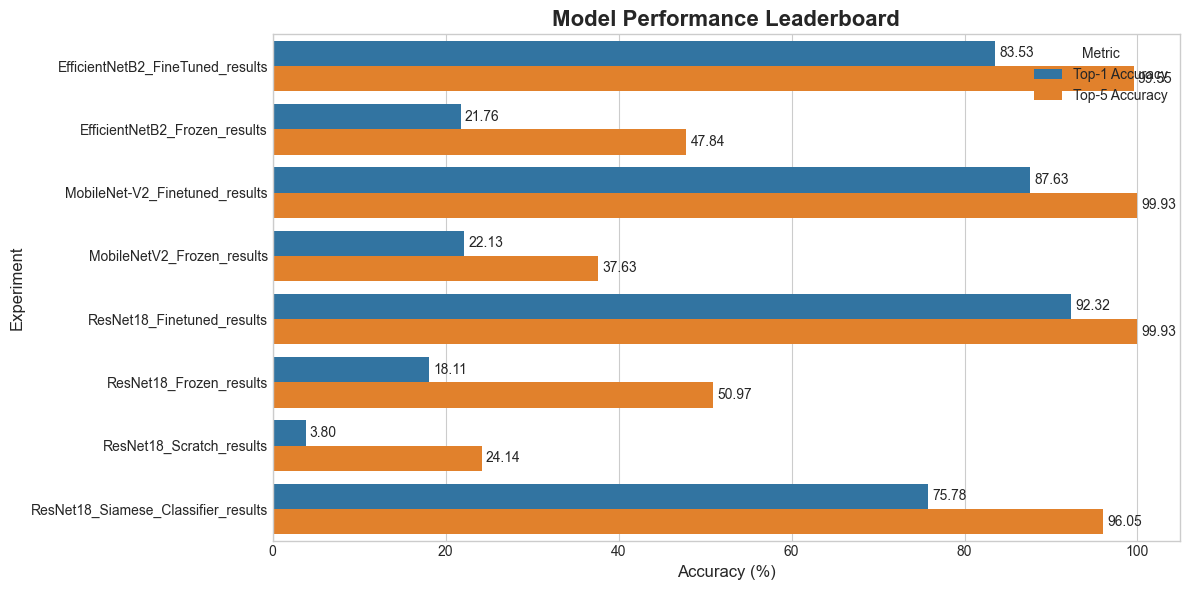

In [50]:
# --- Plot 1: Leaderboard ---
fig_leaderboard = plot_leaderboard(all_data_df)
fig_leaderboard.savefig(os.path.join(PLOTS_DIR, "leaderboard_comparison.png"), dpi=300)
print("Saved leaderboard plot.")

Saved F1-score heatmap.


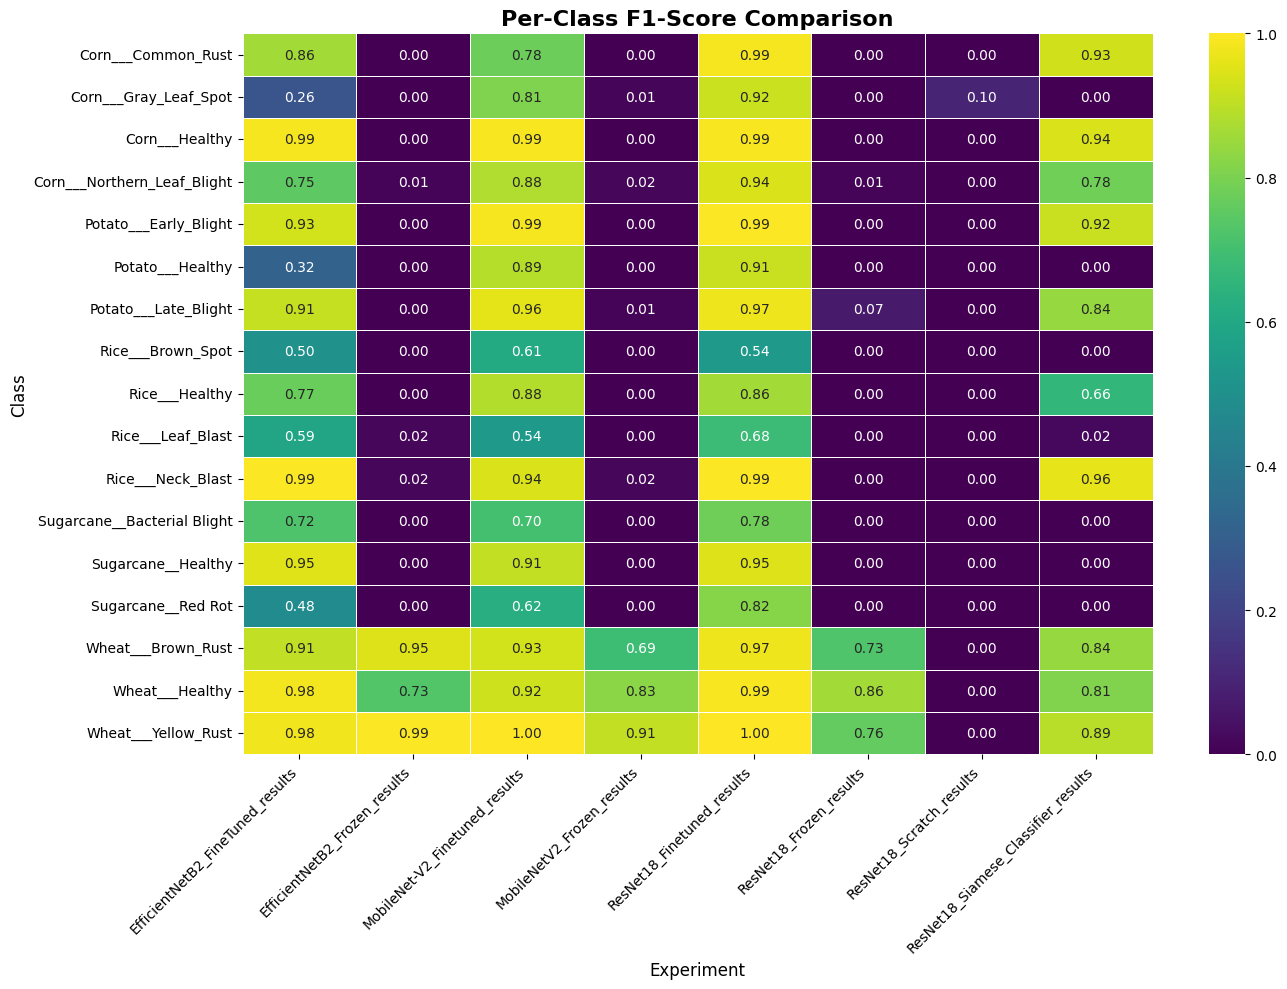

In [51]:
# --- Plot 2: F1-Score Heatmap ---
fig_f1_heatmap = plot_f1_heatmap(all_data_df)
fig_f1_heatmap.savefig(os.path.join(PLOTS_DIR, "2_f1_score_heatmap.png"), dpi=300)
print("Saved F1-score heatmap.")

C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\154177067.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[class_names[j] for j in hardest_indices], y=errors_per_class[hardest_indices], ax=ax, palette='Reds_r')
C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\154177067.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[class_names[j] for j in hardest_indices], y=errors_per_class[hardest_indices], ax=ax, palette='Reds_r')
C:\Users\Gadge\AppData\Local\Temp\ipykernel_22500\154177067.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.ba

Saved hardest classes analysis.


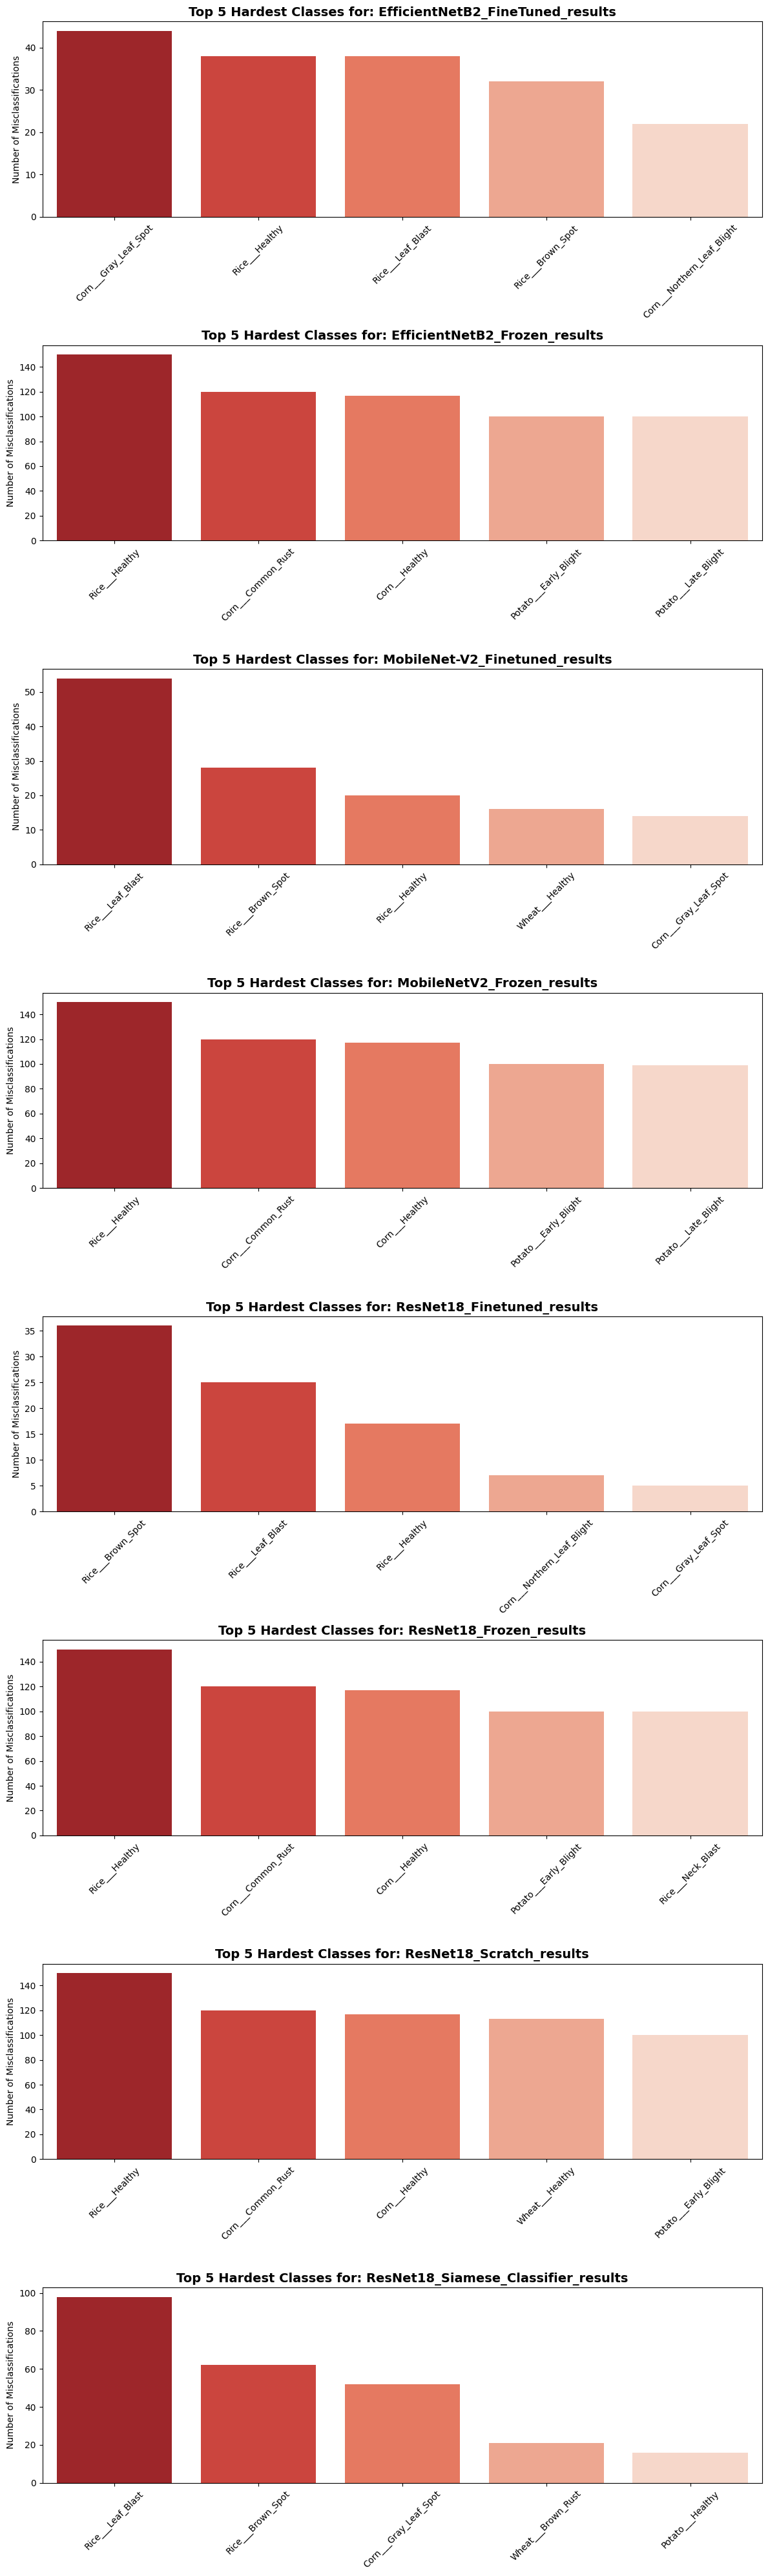

In [52]:
# --- Plot 3: Hardest Classes Analysis ---
fig_hardest_classes = plot_hardest_classes(RESULTS_ROOT, top_n=5)
fig_hardest_classes.savefig(os.path.join(PLOTS_DIR, "3_hardest_classes_analysis.png"), dpi=300)
print("Saved hardest classes analysis.")

In [ ]:
# model size to be added

In [127]:
import tensorflow as tf
from pathlib import Path
import sys

EXPERIMENT_DIR = "runs"

def find_scalar_tags(experiment_dir):
    """Scans the event file in a directory and prints all scalar tags."""
    event_dir = Path(experiment_dir)
    if not event_dir.is_dir():
        print(f"Error: Directory not found at '{event_dir}'")
        return

    event_files = list(event_dir.glob("events.out.tfevents.*"))
    if not event_files:
        print(f"No event files found in '{event_dir}'")
        return

    # Use the first event file found
    filepath = event_files[0]
    tags = set()
    
    print(f"\nScanning tags in: {filepath.name}...")
    try:
        for event in tf.compat.v1.train.summary_iterator(str(filepath)):
            for value in event.summary.value:
                if value.HasField('simple_value'): # This identifies it as a scalar
                    tags.add(value.tag)
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return
        
    if tags:
        print("\nFound the following scalar tags:")
        for tag in sorted(list(tags)):
            print(f"  - '{tag}'")
        print("\nLook for the tags related to validation accuracy and loss in the list above.")
    else:
        print("No scalar tags were found in this event file.")


exps = [os.path.join(EXPERIMENT_DIR, d) for d in os.listdir(EXPERIMENT_DIR)]

for exp in exps:
    find_scalar_tags(exp)

ModuleNotFoundError: No module named 'tensorflow'